# FINAL CHALLENGE

SARA MARTIN VELA - 100498372

DANIELA KURAK - 100498110

LOGAN JACURAK - 100547892

SILVIA CUERVAS BRAGADO - 100498185

MAR CURIEL GARCIA - 100498291

ALMUDENA DE PABLO HUETE - 100498354



# PART 1: Data Collect

For the final challenge, we conducted an insightful analysis of the relationship between Airbnb demand and key factors such as prices, reviews, and neighborhoods across various Spanish regions, specifically Madrid, Málaga, Barcelona, Mallorca, and Menorca. 
Our study aims to uncover patterns and trends that can provide actionable insights for hosts and travelers, helping to optimize pricing strategies, enhance guest experiences, and understand regional differences in the Airbnb market.

## 1.1 Data loading


The files' columns were reviewed in Excel before determining their relevance. For our analysis, we chose to import the calendar.csv.gz and listing.csv.gz files. The listing file contains detailed data on prices, reviews, accommodation characteristics, and neighborhoods. Meanwhile, the calendar file provides essential information about occupancy, availability, and dates for each of the IDs listed in our selected regions.

In [6]:
import os
import pandas as pd

# Base path where city data is located
base_path = 'AIRBNB_SPAIN'

dtype_listings = {
    'id': 'Int64',
    'listing_url': 'str',
    'neighbourhood_cleansed': 'str',
    'neighbourhood_group_cleansed': 'str',
    'latitude': 'float64',
    'longitude': 'float64',
    'room_type': 'str',
    'accommodates': 'Int64',
    'bathrooms_text': 'str',  # Will be processed to extract numeric values
    'bedrooms': 'Int64',
    'beds': 'Int64',
    'price': 'str',  # Will be cleaned and converted to float
    'minimum_nights': 'Int64',
    'maximum_nights': 'Int64',
    'availability_365': 'Int64',
    'number_of_reviews': 'Int64',
    'number_of_reviews_ltm': 'Int64',
    'review_scores_rating': 'float64',
    'reviews_per_month': 'float64'
}

# Dictionary for boolean value converters
bool_converters = {
    'available': lambda x: 1 if x == 't' else 0  # Convert 't' to 1 (True) and 'f' to 0 (False) in calendar.csv
}

# Function to load data for a specific city
def load_city_data(city_name):
    city_path = os.path.join(base_path, city_name)
    files = os.listdir(city_path)
    
    # Dictionary to store the loaded data
    data = {}
    
    for file in files:
        file_path = os.path.join(city_path, file)
        
        # Check if the file is a CSV
        if file.endswith('.csv') or file.endswith('.csv.gz'):
            # If the file is listings.csv.gz
            if 'listings' in file:
                # Read only the necessary columns from listings.csv.gz
                listings_data = pd.read_csv(
                    file_path, 
                    compression='gzip',       # Decompress .gz files
                    decimal='.',              # Use a period as the decimal separator
                    dtype=dtype_listings,     # Specify data types
                    converters=bool_converters,  # Converters for boolean values
                    usecols=[
                        'id', 'listing_url', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude',
                        'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
                        'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews',
                        'number_of_reviews_ltm', 'review_scores_rating', 'reviews_per_month'
                    ]
                )
                # Clean the '$' symbol in the 'price' column (if present) and convert it to float
                if 'price' in listings_data.columns:
                    listings_data['price'] = listings_data['price'].str.replace('[$,]', '', regex=True).astype(float)
                
                # Process bathrooms_text: Extract numeric values and drop the original column
                if 'bathrooms_text' in listings_data.columns:
                    listings_data['bathrooms'] = listings_data['bathrooms_text'].str.extract(r'(\d+)').astype(float)
                    listings_data.drop(columns=['bathrooms_text'], inplace=True)
                
                data['listings'] = listings_data
            
            # If the file is calendar.csv.gz
            elif 'calendar' in file:
                calendar_data = pd.read_csv(
                    file_path, 
                    compression='gzip',       # Decompress .gz files
                    decimal='.',              # Use a period as the decimal separator
                    parse_dates=['date'], 
                    converters=bool_converters, 
                    usecols=['listing_id', 'date', 'available', 'price']  # Select only relevant columns
                )
                # Clean the '$' symbol in the 'price' column (if present) and convert it to float
                if 'price' in calendar_data.columns:
                    calendar_data['price'] = calendar_data['price'].str.replace('[$,]', '', regex=True).astype(float)
                
                data['calendar'] = calendar_data
   
    return data

# List of city folders
cities = [
    'Barcelona', 'Malaga', 'Madrid', 'Mallorca', 'Menorca'
]

# Load data for all cities
all_data = {}
for city in cities:
    print(f"Loading data for {city}...")
    all_data[city] = load_city_data(city)




Loading data for Barcelona...
Loading data for Malaga...
Loading data for Madrid...
Loading data for Mallorca...
Loading data for Menorca...


## 1.2 Inspecting the Data

To ensure the files were properly imported, we inspected the data by printing the first rows, analyzing the number of missing values per column, and generating a statistical summary.

In [9]:
def inspect_file(data_dict, city, file_key):
    """
    Inspect a file within the loaded data.
    
    :param data_dict: Dictionary containing loaded data for all cities.
    :param city: Name of the city to inspect.
    :param file_key: Key of the file within the dictionary ('listings' or 'calendar').
    """
    try:
        # Validate that the city exists in the dictionary
        if city not in data_dict:
            print(f"The city '{city}' is not in the data.")
            return
        
        # Validate that the file exists in the city's data
        if file_key not in data_dict[city]:
            print(f"The file '{file_key}' was not found for the city '{city}'.")
            return
        
        df = data_dict[city][file_key]  # Extract the corresponding DataFrame
        print(f"\n=== Inspection of the file '{file_key}' for the city '{city}' ===\n")
        
        print("--- DataFrame Summary ---")
        print(df.info())  # General information about the DataFrame
        print("\n")
        
        print("--- First Rows ---")
        print(df.head())  # Display the first few rows of the DataFrame
        print("\n")
        
        print("--- Statistical Summary ---")
        print(df.describe(include='all'))  # Statistical summary of all columns
        print("\n")
        
        print("--- Missing Values by Column ---")
        print(df.isnull().sum())  # Missing values per column
        print("\n")
        
        # Identify columns with mixed types
        print("--- Columns with Possible Mixed Data Types ---")
        for col in df.columns:
            if df[col].map(type).nunique() > 1:
                print(f"Column '{col}' has mixed data types. Examples of types:")
                print(df[col].map(type).value_counts())

        print("\n=== Inspection Completed ===")
    except KeyError:
        print(f"The file '{file_key}' was not found in the data for the city '{city}'.")
    except Exception as e:
        print(f"Error inspecting '{file_key}' for '{city}': {e}")




Although only the Barcelona file is shown being inspected here, I imported each file individually to check its content. During this process, I noticed that the calendar.csv files were quite large, containing around 7 to 9 million rows of data. This is because, for each listing, the file reviews all the days of the year it was occupied, with each day represented as a row. This posed a challenge due to the repetitive and voluminous data, requiring significant reduction. On the positive side, the columns had no missing values, which was a helpful aspect.

In [11]:
# Inspect a file of my choice
inspect_file(all_data, 'Barcelona', 'calendar')




=== Inspection of the file 'calendar' for the city 'Barcelona' ===

--- DataFrame Summary ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7110934 entries, 0 to 7110933
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   listing_id  int64         
 1   date        datetime64[ns]
 2   available   int64         
 3   price       float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 217.0 MB
None


--- First Rows ---
   listing_id       date  available  price
0      331026 2024-09-07          0   40.0
1      331026 2024-09-08          0   40.0
2      331026 2024-09-09          0   40.0
3      331026 2024-09-10          0   40.0
4      331026 2024-09-11          0   40.0


--- Statistical Summary ---
         listing_id                           date     available         price
count  7.110934e+06                        7110934  7.110934e+06  7.110934e+06
mean   4.645671e+17  2025-03-07 06:32:46.872760576  4.8558

Upon reviewing the listings.csv file, I observed that this dataset for all five regions was much smaller than the calendar data, with approximately 25,000 rows per file. However, the listings.csv file contained numerous missing values in critical variables such as price, beds, bedrooms, and review-related fields. These missing values needed to be addressed and filled appropriately.

In [13]:
inspect_file(all_data, 'Madrid', 'listings')



=== Inspection of the file 'listings' for the city 'Madrid' ===

--- DataFrame Summary ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26980 entries, 0 to 26979
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            26980 non-null  Int64  
 1   listing_url                   26980 non-null  object 
 2   neighbourhood_cleansed        26980 non-null  object 
 3   neighbourhood_group_cleansed  26980 non-null  object 
 4   latitude                      26980 non-null  float64
 5   longitude                     26980 non-null  float64
 6   room_type                     26980 non-null  object 
 7   accommodates                  26980 non-null  Int64  
 8   bedrooms                      24437 non-null  Int64  
 9   beds                          21018 non-null  Int64  
 10  price                         21068 non-null  float64
 11  minimum_nights             

To better understand the data within the calendar files, I examined the range of dates in all the files. I discovered that the data only covered one year, from mid-2024 to mid-2025. As a result, we determined that a retrospective analysis of the different cities was not feasible due to the lack of historical data. Instead, we decided to focus our analysis specifically on occupancy and pricing in relation to the various house offerings.

In [15]:
# Function to get the date range from the calendar for each city
def get_calendar_date_range(city_data):
    calendar = city_data['calendar']
    min_date = calendar['date'].min()
    max_date = calendar['date'].max()
    return min_date, max_date

# Get the date ranges for each city
date_ranges = {}
for city in cities:
    min_date, max_date = get_calendar_date_range(all_data[city])
    date_ranges[city] = (min_date, max_date)

# Display the date ranges for each city
for city, (min_date, max_date) in date_ranges.items():
    print(f"Date range for {city}: from {min_date} to {max_date}")


Date range for Barcelona: from 2024-09-06 00:00:00 to 2025-09-06 00:00:00
Date range for Malaga: from 2024-06-30 00:00:00 to 2025-06-30 00:00:00
Date range for Madrid: from 2024-09-11 00:00:00 to 2025-09-10 00:00:00
Date range for Mallorca: from 2024-09-13 00:00:00 to 2025-09-13 00:00:00
Date range for Menorca: from 2024-06-30 00:00:00 to 2025-06-29 00:00:00


# PART 2: Data Processing


## 2.1 Merging the Data

To make the data more manageable, we decided to merge everything into a single file. This approach allowed us to work with a unified dataset, eliminating the need to constantly reference the 10 imported files.

### 2.1.1 Processing and Merging Calendars


As mentioned earlier, the calendar files contained around 9 million rows each, and with data from five regions, this totaled approximately 45 million rows. Directly merging these files was not feasible due to the risk of overloading the system. Since the calendar data represented daily records of occupancy, we decided to group the occupancy data by month and create new columns for months, years, and seasons.

This approach significantly reduced the dataset, resulting in a merged calendar file with fewer than 1 million rows. To verify the accuracy of the merge, we printed statistical summaries, which confirmed that the operation was successful. Additionally, we created a new column for "city" to distinguish the IDs corresponding to different cities.

In [21]:
import pandas as pd

# Function to determine the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Function to process and group the calendar data by city
def process_calendar_data(city_data, city_name):
    calendar_data = city_data['calendar']
    
    # Ensure that the 'date' column is in datetime format
    calendar_data['date'] = pd.to_datetime(calendar_data['date'], errors='coerce')
    
    # Create columns for month, year, and season
    calendar_data['month'] = calendar_data['date'].dt.month
    calendar_data['year'] = calendar_data['date'].dt.year
    calendar_data['season'] = calendar_data['date'].dt.month.apply(get_season)

    # Calculate occupancy per month (1 if occupied, 0 if available)
    calendar_data['occupation'] = (calendar_data['available'] == 0).astype(int)
       
    # Group by 'listing_id', 'month', 'season', 'year' and calculate monthly occupancy and average price
    calendar_monthly = calendar_data.groupby(['listing_id', 'month', 'season', 'year']).agg(
        occupation_per_month=('occupation', 'sum'),
    ).reset_index()
    
    # Add 'city' column to avoid mixing data from different cities
    calendar_monthly['city'] = city_name
    
    return calendar_monthly

# Process the data for each city and store the results
processed_data = []
for city, city_data in all_data.items():
    print(f"Processing calendar data for {city}...")
    calendar_monthly = process_calendar_data(city_data, city)  # Pass the city name
    processed_data.append(calendar_monthly)

# Combine the processed results of all cities into a single DataFrame
final_calendar = pd.concat(processed_data, ignore_index=True)

# View the first few rows of the final result to ensure the concatenation was successful
print(f"Final data after concatenation:\n", final_calendar.head(5))




Processing calendar data for Barcelona...
Processing calendar data for Malaga...
Processing calendar data for Madrid...
Processing calendar data for Mallorca...
Processing calendar data for Menorca...
Final data after concatenation:
    listing_id  month  season  year  occupation_per_month       city
0       18674      1  Winter  2025                    26  Barcelona
1       18674      2  Winter  2025                    28  Barcelona
2       18674      3  Spring  2025                    31  Barcelona
3       18674      4  Spring  2025                    30  Barcelona
4       18674      5  Spring  2025                    31  Barcelona


In [22]:
# Se the statistic results of our dataframe to know what are we dealing with
print(final_calendar.describe())


         listing_id          month           year  occupation_per_month
count  9.957170e+05  995717.000000  995717.000000         995717.000000
mean   4.916672e+17       6.654801    2024.654801             14.592720
std    4.957658e+17       3.377546       0.475434             13.641334
min    1.867400e+04       1.000000    2024.000000              0.000000
25%    3.127996e+07       4.000000    2024.000000              0.000000
50%    5.795779e+17       7.000000    2025.000000             12.000000
75%    9.882079e+17       9.000000    2025.000000             30.000000
max    1.244260e+18      12.000000    2025.000000             31.000000


### 2.1.2 Merging Listings


For the merger of the listings files, we decided to address the missing values after completing the merge, rather than before. We combined the five listings files without needing to reduce the data, ensuring that all information was retained for further analysis.

In [25]:
# Concatenate the listings files from different cities
listings_data = []
for city, city_data in all_data.items():
    print(f"Concatenating listings data for {city}...")
    listings_data.append(city_data['listings'])

# Concatenate all the dataframes into one
concatenated_listings = pd.concat(listings_data, ignore_index=True)

# Display the first glance at the concatenated listings
print(concatenated_listings.describe())


Concatenating listings data for Barcelona...
Concatenating listings data for Malaga...
Concatenating listings data for Madrid...
Concatenating listings data for Mallorca...
Concatenating listings data for Menorca...
                          id      latitude     longitude  accommodates  \
count                76796.0  76796.000000  76796.000000       76796.0   
mean    491661065884646976.0     40.038561     -0.374911      3.980637   
std     495696410447734080.0      1.357620      3.322187      2.462142   
min                  18674.0     36.646012     -4.584345           1.0   
25%              31299768.25     39.733320     -3.703820           2.0   
50%     579605896397837952.0     40.410840      2.146515           4.0   
75%     988127140536320128.0     41.371320      2.658418           6.0   
max    1244260393819796224.0     41.456377      4.304030          16.0   

       bedrooms      beds        price  minimum_nights  maximum_nights  \
count   72075.0   65101.0  65171.00000     

### 2.1.3 Creating a unique dataset


We merged the two datasets we had created, listings and calendar, into a single comprehensive dataset called total_df. This unified dataset contained all the necessary information for our analysis. We also saved it as a separate CSV file for easier access and further processing.

In [28]:
# Rename the 'listing_id' column in final_calendar to match 'id' in concatenated_listings
final_calendar.rename(columns={'listing_id': 'id'}, inplace=True)

# Perform the inner join between the listings DataFrame and final_calendar using 'id' as the common key
total_df = pd.merge(concatenated_listings, final_calendar, on='id', how='inner')

# View the first rows of the final result after the merge
print(total_df.describe())


# Save the final file after the merge
total_df.to_csv('merged_data.csv', index=False)


                          id       latitude      longitude  accommodates  \
count               995717.0  995717.000000  995717.000000      995717.0   
mean    491667193655952320.0      40.047326      -0.364218      3.980118   
std     495765781677152128.0       1.348639       3.320025      2.462831   
min                  18674.0      36.646012      -4.584345           1.0   
25%               31279955.0      39.736749      -3.703670           2.0   
50%     579577943307790080.0      40.410950       2.147070           4.0   
75%     988207855305233024.0      41.371592       2.660161           6.0   
max    1244260393819796224.0      41.456377       4.304030          16.0   

       bedrooms      beds          price  minimum_nights  maximum_nights  \
count  934403.0  844005.0  844915.000000        995717.0        995717.0   
mean   1.961484  2.830808     217.030958        8.218315      568.119605   
std    1.350188  2.229103     593.546960       25.263151      441.329974   
min        

## 2.2 Tracking & Deleting Errors


With all our tables merged into a single file, we conducted a statistical analysis to verify that all columns were correctly imported. During this process, we identified some outliers that could distort the data, particularly in critical variables such as price, beds, bedrooms, and bathrooms. We decided to address these outliers, focusing on those that were most significant to our analysis.

### 2.2.1 Clean beds column

To clean the beds column, I examined the ranges of bed counts that seemed out of place. For the analysis, I filtered the dataset to only include unique values of IDs, which resulted in seven rows. 
I manually reviewed these entries by visiting the Airbnb listings through their links. Upon inspection, I identified obvious outliers—ads that had incorrectly listed the number of beds, often for rented rooms with shared kitchens and unique room ads. I decided to eliminate five of these entries, as they were clear outliers and did not add significant value to the analysis.

In [33]:
filtered_df = total_df[(total_df['beds'] >= 30) & (total_df['beds'] <= 50)]

# Remove duplicate records based on 'id'
filtered_df_unique = filtered_df.drop_duplicates(subset='id')

# Display the filtered result without duplicate ids
print(filtered_df_unique)



                        id                                      listing_url  \
42562             17474580            https://www.airbnb.com/rooms/17474580   
283567  579573978843500411  https://www.airbnb.com/rooms/579573978843500411   
300608  580102120331939962  https://www.airbnb.com/rooms/580102120331939962   
529576  590309986337177910  https://www.airbnb.com/rooms/590309986337177910   
608551            40871059            https://www.airbnb.com/rooms/40871059   
741801            14181351            https://www.airbnb.com/rooms/14181351   
879081  846380353294202559  https://www.airbnb.com/rooms/846380353294202559   

       neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
42562      la Sagrada Família                     Eixample  41.402676   
283567                 Centro                          NaN  36.724600   
300608                 Centro                          NaN  36.724100   
529576            Embajadores                       Centro  40.413480   
60

In [34]:
# IDs to be removed
ids_to_remove = [17474580, 580102120331939962, 590309986337177910, 40871059, 1142485100279703723]

# Remove rows with the specified IDs
total_df = total_df[~total_df['id'].isin(ids_to_remove)]

# Check the result
print(total_df['beds'].describe())


count    843941.0
mean     2.826507
std      2.152487
min           0.0
25%           1.0
50%           2.0
75%           4.0
max          50.0
Name: beds, dtype: Float64


### 2.2.2 Clean bedrooms column

For the bedrooms column, I focused on all IDs with more than 15 bedrooms, as such a high number might indicate errors (this is not a typical value for most listings). This filter resulted in 12 rows matching the description. Upon review, some entries were accurate, such as listings for a conglomerate of houses or a castle-like property. However, other ads had incorrectly listed the number of bedrooms. Instead of deleting these entries, I corrected the bedroom count to the actual number, which was 1, based on the listing details.

In [37]:
df_1 = total_df[total_df["bedrooms"] > 15]

df_1_unique = df_1.drop_duplicates(subset='id')

print(df_1_unique)


                         id                                       listing_url  \
193245   988887345495530621   https://www.airbnb.com/rooms/988887345495530621   
203489  1051338207146039925  https://www.airbnb.com/rooms/1051338207146039925   
251693  1230311605131296050  https://www.airbnb.com/rooms/1230311605131296050   
283567   579573978843500411   https://www.airbnb.com/rooms/579573978843500411   
404334             49238159             https://www.airbnb.com/rooms/49238159   
601570             51204846             https://www.airbnb.com/rooms/51204846   
741801             14181351             https://www.airbnb.com/rooms/14181351   
768204             23041310             https://www.airbnb.com/rooms/23041310   
784155             30849281             https://www.airbnb.com/rooms/30849281   
879081   846380353294202559   https://www.airbnb.com/rooms/846380353294202559   
912920  1093995572981348550  https://www.airbnb.com/rooms/1093995572981348550   
922579  1149313479235257144 

In [38]:
total_df.loc[total_df['id'].isin([51204846, 988887345495530621]), ['bedrooms', 'beds']] = 1

print(total_df['bedrooms'].describe())


count    934339.0
mean     1.959976
std      1.331631
min           0.0
25%           1.0
50%           2.0
75%           3.0
max          24.0
Name: bedrooms, dtype: Float64


### 2.2.2 Clean bathrooms column

For the bathrooms column, I applied the same approach as with the bedrooms column. I identified rows with implausibly high numbers of bathrooms, and since the number of such errors was minimal, I opted to correct these entries by setting the bathroom count to 1. This ensured the data remained accurate and consistent without significantly impacting the dataset size.

In [41]:
df_3 = total_df[total_df["bathrooms"] > 15]

df_3_unique = df_3.drop_duplicates(subset='id')

print(df_3_unique)


                         id                                       listing_url  \
768204             23041310             https://www.airbnb.com/rooms/23041310   
879081   846380353294202559   https://www.airbnb.com/rooms/846380353294202559   
900310  1008616949883586625  https://www.airbnb.com/rooms/1008616949883586625   

       neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
768204               Felanitx                          NaN  39.414560   
879081              Sencelles                          NaN  39.679173   
900310      Palma de Mallorca                          NaN  39.575657   

        longitude        room_type  accommodates  bedrooms  beds  ...  \
768204   3.215890  Entire home/apt            16        20    28  ...   
879081   2.905846  Entire home/apt            16        16    32  ...   
900310   2.639253     Private room             1         2     1  ...   

        number_of_reviews  number_of_reviews_ltm  review_scores_rating  \
768204         

In [42]:
total_df.loc[total_df['id'].isin([1008616949883586625]), ['bathrooms']] = 1

print(total_df['bathrooms'].describe())

count    987115.000000
mean          1.532058
std           0.966421
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          19.000000
Name: bathrooms, dtype: float64


### 2.2.3 Clean price column

Cleaning the price column was particularly challenging due to the difficulty in defining a realistic range (e.g., €15,000 per night is an exorbitant amount). 

**First Cleanup:**  
Initially, I filtered for listings with prices greater than €2,000 per night and fewer than 1 bedroom. It seemed highly unlikely for a place with such minimal accommodations to charge that much, and upon investigation, I confirmed this was the case. None of these listings were priced accurately on the Airbnb platform, with actual prices not exceeding €300 per night. Since manually correcting all 68 rows was impractical, I decided to delete these entries.

**Second Cleanup:**  
Next, I broadened the scope by filtering for listings with prices higher than €5,000 per night. This resulted in 114 rows. After checking at least 50 links, I found that most of these listings either no longer existed on Airbnb or were incorrectly priced. As a result, I decided to delete these entries as well.

**Third Cleanup:**  
Finally, I examined listings with prices between €3,000 and €5,000 per night. After conducting thorough research and verifying the listings individually, I discovered that these prices were accurate. Some entire houses in central Madrid and Barcelona, as well as large beachfront properties during the summer, were legitimately priced in this range. These findings were surprising, but they validated the data. Consequently, I decided not to delete or modify these entries and removed this step from the cleanup process.

**Final Decision:**  
We have been working with prices below €5,000 per night, as they are the most reliable and realistic range for our analysis. This approach ensures the data remains accurate and representative of actual market conditions.

In [45]:
df_4 = total_df[(total_df["price"] > 2000) & (total_df["bedrooms"] <= 1)]

df_4_unique = df_4.drop_duplicates(subset='id')

columns_to_display = ['id', 'listing_url', 'price', 'room_type', 'bedrooms',  'beds','bathrooms']

print(df_4_unique[columns_to_display])

                         id                                       listing_url  \
147732   706990889247317671   https://www.airbnb.com/rooms/706990889247317671   
170209   867256504774715226   https://www.airbnb.com/rooms/867256504774715226   
205933  1060266404133622778  https://www.airbnb.com/rooms/1060266404133622778   
205946  1060266644272581285  https://www.airbnb.com/rooms/1060266644272581285   
205959  1060266855327829744  https://www.airbnb.com/rooms/1060266855327829744   
...                     ...                                               ...   
988424  1067512988041510094  https://www.airbnb.com/rooms/1067512988041510094   
988437  1067513294665660335  https://www.airbnb.com/rooms/1067513294665660335   
988450  1067513654909021017  https://www.airbnb.com/rooms/1067513654909021017   
988463  1067514145784303334  https://www.airbnb.com/rooms/1067514145784303334   
991635  1118000888834723417  https://www.airbnb.com/rooms/1118000888834723417   

         price        room_

In [46]:
# Get unique IDs from df_4
ids_to_remove = df_4['id'].unique()

# Remove rows from the original DataFrame that match these IDs
total_df = total_df[~total_df['id'].isin(ids_to_remove)]

# Check that the rows have been removed
print(total_df.describe())

                          id       latitude      longitude  accommodates  \
count               994770.0  994770.000000  994770.000000      994770.0   
mean    491499265238167808.0      40.048061      -0.364005      3.980673   
std     495751267762251712.0       1.348164       3.319684      2.462134   
min                  18674.0      36.646012      -4.584345           1.0   
25%               31257581.0      39.737300      -3.703661           2.0   
50%     579451572129994240.0      40.410970       2.147070           4.0   
75%     987624449769665792.0      41.371660       2.660072           6.0   
max    1244260393819796224.0      41.456377       4.304030          16.0   

       bedrooms      beds          price  minimum_nights  maximum_nights  \
count  933456.0  843058.0  843968.000000        994770.0        994770.0   
mean   1.961022  2.827357     209.679876        8.219149      567.966411   
std    1.331782  2.152168     533.445606       25.251661        441.3185   
min        

In [47]:
df_6 = total_df[(total_df["price"] > 5000)]

df_6_unique = df_6.drop_duplicates(subset='id')

print(df_6_unique[columns_to_display])

                         id                                       listing_url  \
252174  1231711118201011175  https://www.airbnb.com/rooms/1231711118201011175   
303059  1188530888377233411  https://www.airbnb.com/rooms/1188530888377233411   
384496  1087700981397177073  https://www.airbnb.com/rooms/1087700981397177073   
418426   612030162376917657   https://www.airbnb.com/rooms/612030162376917657   
474937  1083236123092383967  https://www.airbnb.com/rooms/1083236123092383967   
...                     ...                                               ...   
929885  1183691023103059566  https://www.airbnb.com/rooms/1183691023103059566   
931575  1191399345378459761  https://www.airbnb.com/rooms/1191399345378459761   
934474  1204216578247351065  https://www.airbnb.com/rooms/1204216578247351065   
937217  1212123159968628493  https://www.airbnb.com/rooms/1212123159968628493   
937477  1212654172043488201  https://www.airbnb.com/rooms/1212654172043488201   

          price        room

In [48]:
# Get unique IDs from df_6
ids_to_remove = df_6['id'].unique()

# Remove rows with those IDs from the original DataFrame
total_df = total_df[~total_df['id'].isin(ids_to_remove)]

# Visually check the relevant columns after the removal
columns_to_display = ['id', 'listing_url', 'price', 'room_type', 'bedrooms', 'beds', 'bathrooms']
print(total_df[columns_to_display].describe())


                          id          price  bedrooms      beds      bathrooms
count               993288.0  842486.000000  931974.0  841576.0  984763.000000
mean    491419161475048256.0     192.147446  1.958338  2.823577       1.530556
std     495724477063047680.0     218.971183   1.32991  2.150484       0.963747
min                  18674.0       1.000000       0.0       0.0       0.000000
25%               31219990.0      83.000000       1.0       1.0       1.000000
50%     579398188462261760.0     138.000000       2.0       2.0       1.000000
75%     987027640407038336.0     224.000000       3.0       4.0       2.000000
max    1244260393819796224.0    5000.000000      24.0      50.0      19.000000


After cleaning the data, I conducted a final statistical analysis to ensure everything was accurate. Both the bathrooms and beds columns were correct, with the only notable outlier being a castle, which was valid. Additionally, the price column was within the appropriate range, confirming that the data cleanup was successful.

## 2.3 Cleaning Formats


To ensure smooth descriptive analysis and chart creation, it was essential to eliminate blank spaces or n/a values in the dataset. I decided to take a tailored approach for each incomplete column, including neighbourhood_group_cleansed, price, beds, reviews, and similar variables, to address their specific issues effectively.

In [52]:
# Calculate the number of missing values for each column
missing_values = total_df.isnull().sum()

# Display the missing values count by column
print("Missing Values (Count) by Column:")
print(missing_values)

Missing Values (Count) by Column:
id                                   0
listing_url                          0
neighbourhood_cleansed               0
neighbourhood_group_cleansed    389802
latitude                             0
longitude                            0
room_type                            0
accommodates                         0
bedrooms                         61314
beds                            151712
price                           150802
minimum_nights                       0
maximum_nights                       0
availability_365                     0
number_of_reviews                    0
number_of_reviews_ltm                0
review_scores_rating            208670
reviews_per_month               208670
bathrooms                         8525
month                                0
season                               0
year                                 0
occupation_per_month                 0
city                                 0
dtype: int64


For neighbourhood_group_cleansed, I filled the blank spaces with the corresponding value from neighbourhood_cleansed, as it represented the larger group.

For reviews_per_month and review_scores_rating, missing values were filled with 0, indicating that the listings had no reviews. Later, we decided to limit our analysis to listings with existing reviews (scores between 1 and 5).

For numerical columns that could significantly impact the analysis—such as bedrooms, beds, price, and bathrooms—we opted to fill missing values with the median. This approach minimized the distortion of the dataset and maintained consistency. Notably, this adjustment changed the final mean of the price column (the most critical variable for our analysis) from 192 to 183.92


In [54]:
import pandas as pd

# Fill missing values in 'neighbourhood_group_cleansed' with the value from 'neighbourhood_cleansed'
total_df['neighbourhood_group_cleansed'] = total_df['neighbourhood_group_cleansed'].fillna(total_df['neighbourhood_cleansed'])

# Fill missing values in 'reviews_per_month' and 'review_scores_rating' with 0
total_df['reviews_per_month'] = total_df['reviews_per_month'].fillna(0)
total_df['review_scores_rating'] = total_df['review_scores_rating'].fillna(0)

# Fill missing values in numerical columns with the median
numeric_columns = ['bedrooms', 'beds', 'price', 'bathrooms']
for col in numeric_columns:
    median_value = total_df[col].median()
    total_df[col] = total_df[col].fillna(median_value)

# Check if missing values have been replaced
missing_values_after = total_df.isnull().sum()
print("Missing values after filling:")
print(missing_values_after)

print(total_df.describe())


Missing values after filling:
id                              0
listing_url                     0
neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
latitude                        0
longitude                       0
room_type                       0
accommodates                    0
bedrooms                        0
beds                            0
price                           0
minimum_nights                  0
maximum_nights                  0
availability_365                0
number_of_reviews               0
number_of_reviews_ltm           0
review_scores_rating            0
reviews_per_month               0
bathrooms                       0
month                           0
season                          0
year                            0
occupation_per_month            0
city                            0
dtype: int64
                          id       latitude      longitude  accommodates  \
count               993288.0  993288.000000  993288.000000      9

# PART 3: Descriptive Analysis


## 3.2 Insights on Reviews

In [57]:
# Create a copy of the original dataframe to work with
df_ratings_cleaned = total_df.copy()
df_geo_cleaned = total_df.copy()
df_properties = total_df.copy()



As a first step, we create a new dataframe to examine the distribution of review scores. Since a value of 0 should be treated as missing data, we will replace it with NaN in a separate dataframe and then remove the rows were NaN values are showing, to ensure it does not impact our analysis moving forward.

In [59]:
# Replace 0 ratings with NaN
df_ratings_cleaned['review_scores_rating'] = df_ratings_cleaned['review_scores_rating'].replace(0, pd.NA)

# Remove rows where 'review_scores_rating' is NaN
df_ratings_cleaned = df_ratings_cleaned.dropna(subset=['review_scores_rating'])

# Check the distribution of review scores in the cleaned dataframe
print(df_ratings_cleaned['review_scores_rating'].value_counts())
print(f"Minimum score: {df_ratings_cleaned['review_scores_rating'].min()}")
print(f"Maximum score: {df_ratings_cleaned['review_scores_rating'].max()}")




review_scores_rating
5.00    163551
4.00     30155
4.50     27901
4.67     23836
4.75     19036
         ...  
3.09        13
3.46        13
2.74        13
2.73        13
1.85        12
Name: count, Length: 199, dtype: int64
Minimum score: 1.0
Maximum score: 5.0


We examined the distribution of review_scores_rating after cleaning the dataset by eliminating rows that had scores of 0 and replacing them with NaN. According to the cleaned data, there are 199 distinct ratings, ranging from 1.0 (lowest) to 5.0 (highest).

With 5.00 being the most common review score (163,551 times), the distribution shows that most ratings cluster around higher values. 

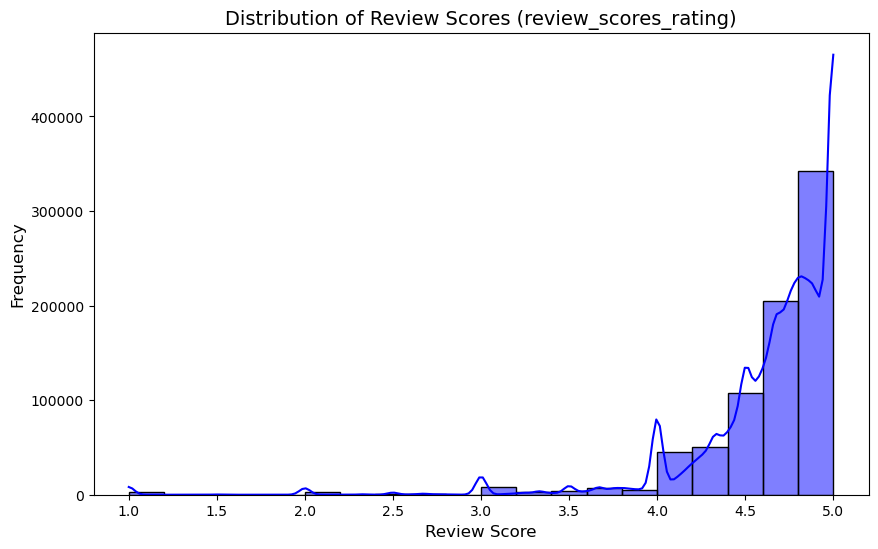

The most common rating is: 5.0


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of review scores in the new dataframe
plt.figure(figsize=(10, 6))
sns.histplot(df_ratings_cleaned['review_scores_rating'], bins=20, kde=True, color='blue')
plt.title('Distribution of Review Scores (review_scores_rating)', fontsize=14)
plt.xlabel('Review Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(False)

plt.show()

# Most common ratings in the new dataframe
most_common_rating = df_ratings_cleaned['review_scores_rating'].mode()[0]
print(f"The most common rating is: {most_common_rating}")




Observation: The majority of ratings are concentrated around the higher end of the scale, particularly around 4.5 and 5 stars, indicating a significant right-skewed distribution of review scores. The data indicates that the majority of consumers are typically satisfied with the product or service, with a score of 5.00 being the most common. A slight tail toward lower ratings, however, suggests sporadic bad experiences. Customers that are extremely satisfied are more likely to submit evaluations, but disappointed customers may not do so as frequently. This could explain the comparatively large amount of reviews with ratings near 5. 

In order to determine how elements such as price, the number of bedrooms, and the number of bathrooms affect the overall review score, we next examined the correlation matrix for review scores with other variables. 

### 3.2.2 Correlation Analysis

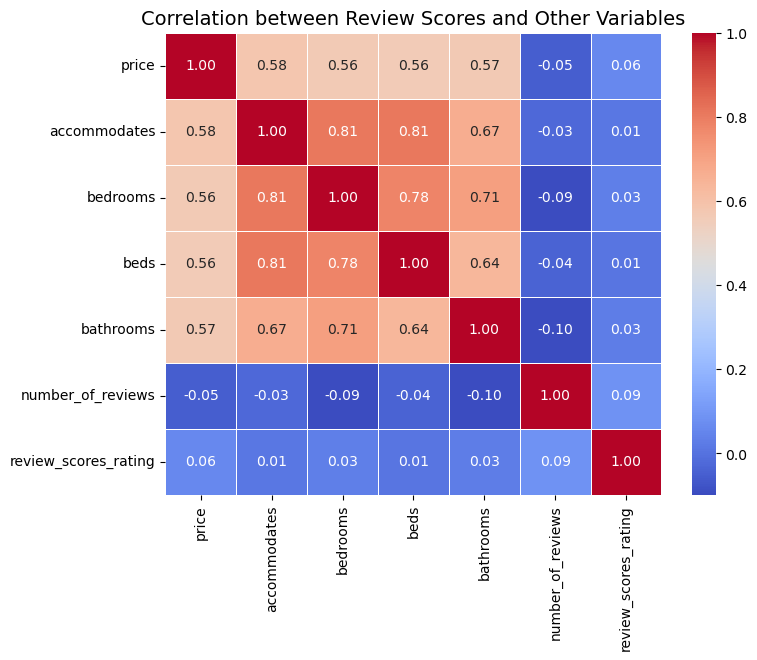

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for correlation analysis
correlation_data = df_ratings_cleaned[['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                                       'number_of_reviews', 'review_scores_rating']]

# Handle missing values by replacing them with the mean of each column
correlation_data = correlation_data.fillna(correlation_data.mean(numeric_only=True))  # Use numeric_only=True for clarity

# Optionally, to avoid warnings in the future:
pd.set_option('future.no_silent_downcasting', True)

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation between Review Scores and Other Variables', fontsize=14)
plt.show()


Review scores show relatively weak relationships with other factors, including price, number of reviews, number of bedrooms, and number of bathrooms, according to the correlation matrix. This implies that the overall review score is not significantly impacted by these factors. In addition to the previous findings, there is a significant positive association between price and the number of bathrooms and bedrooms, suggesting that homes with more bathrooms or bedrooms are typically more costly. Since homes with more bedrooms usually have more bathrooms, there is also a substantial positive correlation between the number of bedrooms and bathrooms. Properties with more bathrooms may obtain less evaluations, maybe as a result of their higher price and exclusivity, according to a modest negative association between the number of reviews and bathrooms. 
Following correlation matrix analysis, we used boxplots to visually examine each variable's distribution and possible outliers. This step is essential because, although the correlation matrix displays the relationships between variables, boxplots provide a more comprehensive understanding of the underlying structure of the data and can highlight possible problems such as skewness, outliers, or odd patterns that the correlation matrix alone might miss

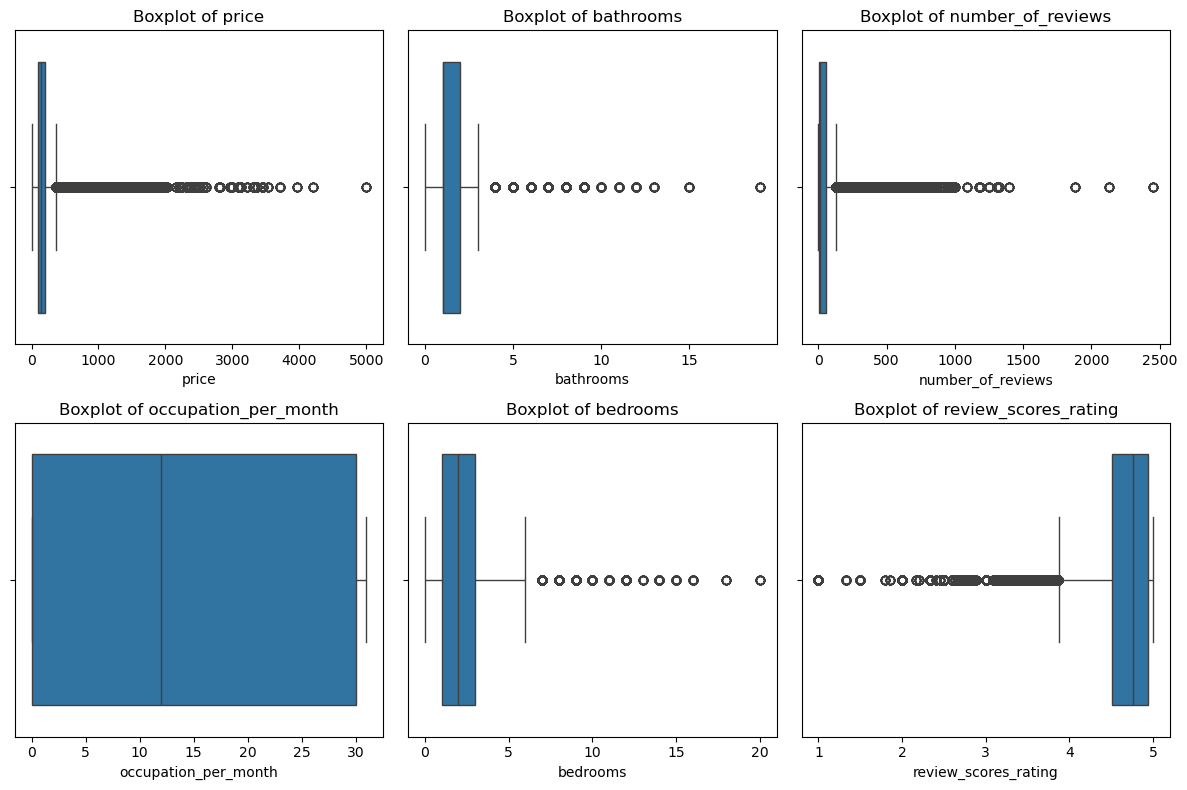

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for idx, col in enumerate(['price', 'bathrooms','number_of_reviews', 'occupation_per_month', 'bedrooms', 'review_scores_rating']):
    plt.subplot(2, 3, idx + 1)
    sns.boxplot(x=df_ratings_cleaned[col])
    plt.title(f"Boxplot of {col}")
    plt.grid(False)

plt.tight_layout()
plt.show()


Relying exclusively on correlation analysis could fail to provide trustworthy insights because important variables such as price, number_of_reviews, and review_scores_rating contain a large number of outliers, as we can see above. Review ratings and other variables have very weak correlations (below 0.08), demonstrating how outliers can distort correlation coefficients. Instead, greater understanding of the structure of the data can be obtained by employing descriptive statistics like mean, median, and measures of spread. By classifying variables according to review_scores_rating, we can reduce the influence of outliers and find significant trends, offering more reliable insights into the ways in which factors like price and number_of_reviews affect review scores.

### 3.2.3 Relationship between Review Scores and Prices

In [69]:
correlation = df_ratings_cleaned[['review_scores_rating', 'price']].corr().iloc[0, 1]
print(f"Correlation between Review Scores and Price: {correlation:.2f}")



Correlation between Review Scores and Price: 0.06


In [70]:
# Filter the data to include only properties with a price of up to 500
filtered_data = df_ratings_cleaned[df_ratings_cleaned['price'] <= 500]

# Calculate the correlation between review scores and price
correlation_filtered = filtered_data[['review_scores_rating', 'price']].corr().iloc[0, 1]

# Display the correlation coefficient
print(f"Correlation between Review Scores and Price (for properties with price <= 500): {correlation_filtered:.2f}")


Correlation between Review Scores and Price (for properties with price <= 500): 0.06


We initially calculated the correlation between review scores and price to understand if there’s any meaningful relationship between how much a property costs and the reviews it receives. Since we noticed that there were extreme outliers in the price data, we decided to filter the dataset to only include properties priced at 500 or below. This allowed us to focus on a more reasonable price range and see if the correlation would change when removing the higher-end properties. However, even with this filter, the correlation remained quite weak, suggesting that price does not significantly influence review scores

In [72]:
grouped_stats = df_ratings_cleaned.groupby('review_scores_rating')['price'].describe()
print(grouped_stats)


                         count        mean          std    min    25%    50%  \
review_scores_rating                                                           
1.00                    3153.0  146.699651   180.544706   14.0   60.0  125.0   
1.33                      39.0  103.000000    40.115622   51.0   51.0  111.0   
1.50                      91.0  527.714286  1001.387041   28.0   40.0  117.0   
1.80                      13.0  184.000000     0.000000  184.0  184.0  184.0   
1.85                      12.0  138.000000     0.000000  138.0  138.0  138.0   
...                        ...         ...          ...    ...    ...    ...   
4.96                    6757.0  214.754181   197.720583   23.0  104.0  155.0   
4.97                    5461.0  222.869438   196.112192   10.0  112.0  159.0   
4.98                    3801.0  217.116811   187.129661   19.0  110.0  160.0   
4.99                    1363.0  213.275862   141.378285   23.0  123.0  190.0   
5.00                  163551.0  205.2875

The relationship between review scores and price shows that properties with higher review scores tend to have higher prices on average, with prices gradually increasing as the rating approaches 5 stars. However, there are some anomalies, such as properties rated 1 star with very low prices and those rated 5 stars with exceptionally low prices (like the one priced at 9). A potential cause for this could be that some guests rate properties highly due to perceived value for money, particularly when the price is low. For example, a property priced very cheaply might receive a high rating because the guest feels they got a good deal, even if the property itself may not be extraordinary. On the other hand, properties with low ratings and low prices could indicate issues with the property, such as poor conditions, which affect the guest’s experience despite the low cost. Additionally, people may have lower expectations for cheaper properties and may rate them more generously if they meet basic expectations, while those staying at higher-priced properties may expect more, leading to a wider spread of ratings at higher price points. This "value for money" perception may be influencing the observed relationship between price and review scores.

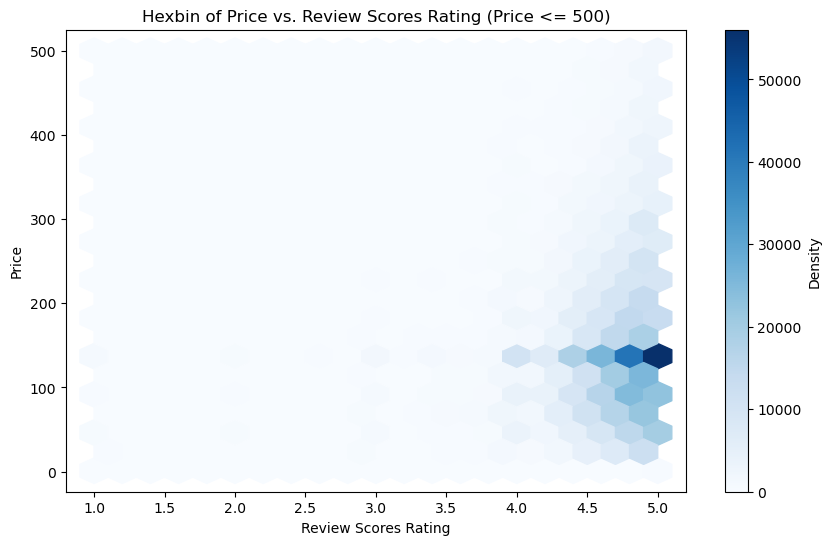

In [74]:
# Hexbin plot to show density of data points
plt.figure(figsize=(10, 6))
plt.hexbin(filtered_data['review_scores_rating'], filtered_data['price'], gridsize=20, cmap='Blues')
plt.colorbar(label='Density')
plt.title('Hexbin of Price vs. Review Scores Rating (Price <= 500)')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price')
plt.show()






The majority of houses priced around 500 euros per night have received good ratings, according to the hexbin plot, which shows a concentration of data points around the higher end of review scores (4.5–5.0). Although there is a small trend, houses with medium prices typically receive slightly better evaluations. Price ranges between 100 and 200 euros per night and review scores between 4.5 and 5.0 are the densest. The graphic doesn't provide precise numbers of properties and is restricted to those that cost less(or equal) than 500 euros per night.

### 3.2.4 Relationship between Review scores and Ocupation per month 

In [77]:
# Calculate the correlation between 'occupation_per_month' and 'review_scores_rating'
correlation = df_ratings_cleaned['occupation_per_month'].corr(df_ratings_cleaned['review_scores_rating'])

# Display the correlation
print("Correlation between occupation_per_month and review_scores_rating:", correlation)


Correlation between occupation_per_month and review_scores_rating: 0.04371722862617925


In [78]:
# Group by 'review_scores_rating' and get descriptive statistics for 'occupation_per_month' and 'review_scores_rating'
grouped_stats = df_ratings_cleaned.groupby('review_scores_rating')[['occupation_per_month', 'review_scores_rating']].describe()

# Display the grouped statistics
print(grouped_stats)




                     occupation_per_month                                  \
                                    count       mean        std  min  25%   
review_scores_rating                                                        
1.00                               3153.0  11.921028  13.749335  0.0  0.0   
1.33                                 39.0   2.538462   8.015925  0.0  0.0   
1.50                                 91.0   9.098901  13.147078  0.0  0.0   
1.80                                 13.0  15.769231  14.709146  0.0  0.0   
1.85                                 12.0   3.666667   8.616404  0.0  0.0   
...                                   ...        ...        ...  ...  ...   
4.96                               6757.0  15.977949  13.033691  0.0  0.0   
4.97                               5461.0  15.478667  12.995172  0.0  0.0   
4.98                               3801.0  15.286240  12.863929  0.0  0.0   
4.99                               1363.0  17.256053  12.402206  0.0  4.0   

There is an apparent trend to the "occupation_per_month" data categorized by "review_scores_rating": properties with lower review scores (1.00 to 1.85), which have a lot fewer bookings, have much lower occupancy rates. A lot of locations with a rating of 1.33, for instance, have zero occupancy, and their mean occupancy is a relatively low 2.5 nights each month. On the other hand, properties with higher review scores (between 4.96 and 5.00) have typical occupancy rates that range from 15.5 to 17.3 occupied nights per month, which indicates substantially higher and more constant occupancy. According to the 75th percentile for these ratings, the majority of properties are booked for up to 30 nights per month, indicating that higher ratings are associated with more regular and high demand reservations.

Higher-rated properties demonstrate more stability in their booking patterns, whereas lower-rated properties show more variance in occupancy, as evidenced by the broader spread between the 25th and 75th percentiles. These results suggest that occupancy is strongly influenced by customer satisfaction, as evidenced by better review rankings.

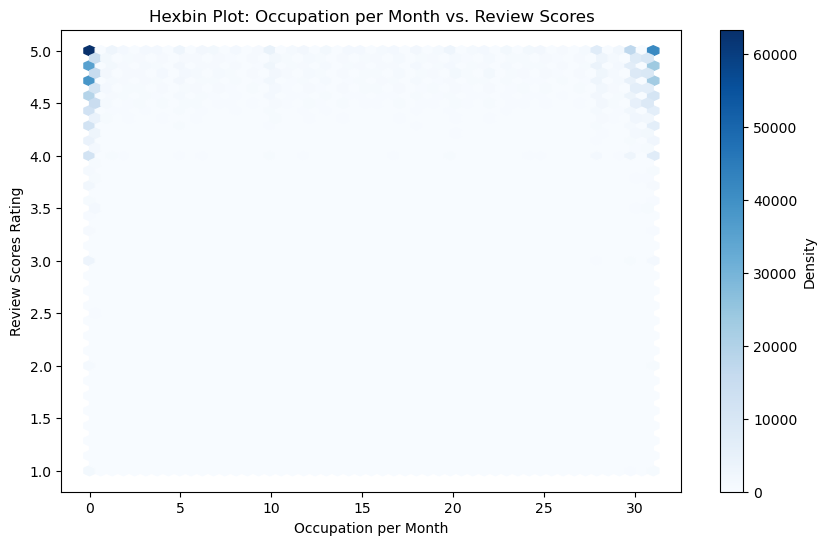

In [80]:
import matplotlib.pyplot as plt

# Create the hexbin plot for occupation per month vs. review scores rating
plt.figure(figsize=(10, 6))
plt.hexbin(df_ratings_cleaned['occupation_per_month'], df_ratings_cleaned['review_scores_rating'], gridsize=50, cmap='Blues')

# Add a color bar
plt.colorbar(label='Density')

# Set labels and title
plt.xlabel('Occupation per Month')
plt.ylabel('Review Scores Rating')
plt.title('Hexbin Plot: Occupation per Month vs. Review Scores')

# Show the plot
plt.show()


The analysis suggests that properties with perfect ratings (5.0) dominate the dataset, showing a wide range of monthly occupation rates. While many have high occupancy, others show really low occupancy. This may be because some of these properties are newer Airbnbs that haven’t been visited by many guests yet, as Airbnb’s popularity continues to grow and attract new hosts. This observation highlights that a perfect rating doesn’t always guarantee high occupancy, especially for newer listings that are still building their reputation.

Conversely, properties with low review scores (1.0-2.0) tend to have consistently lower occupation rates, emphasizing the negative impact of poor ratings on bookings. Meanwhile, properties with mid-to-high ratings (4.5-5.0) have denser distributions of higher occupation rates, confirming that well-rated properties attract more guests on average.

These findings offer actionable insights. New hosts with perfect ratings but low occupancy can focus on marketing strategies to increase visibility and attract more guests. Additionally, mid-range rated properties (4.5-4.8) present an opportunity for growth—by improving guest experiences and raising their ratings, these properties could see a significant boost in bookings.

After looking at the hexbin plot and discovering that certain properties with a 5-star rating had low occupancy rates, we realized that we needed to investigate an additional element: the number of reviews. This was important because, even if the property had a flawless rating, a low number of reviews might suggest that it is new or hasn't been booked extensively yet, which could account for the low occupancy. We can more clearly see whether younger properties with fewer reviews typically have low occupancy, even with high ratings, by integrating the number of reviews in a 3D scatter plot with occupancy per month and review scores. 

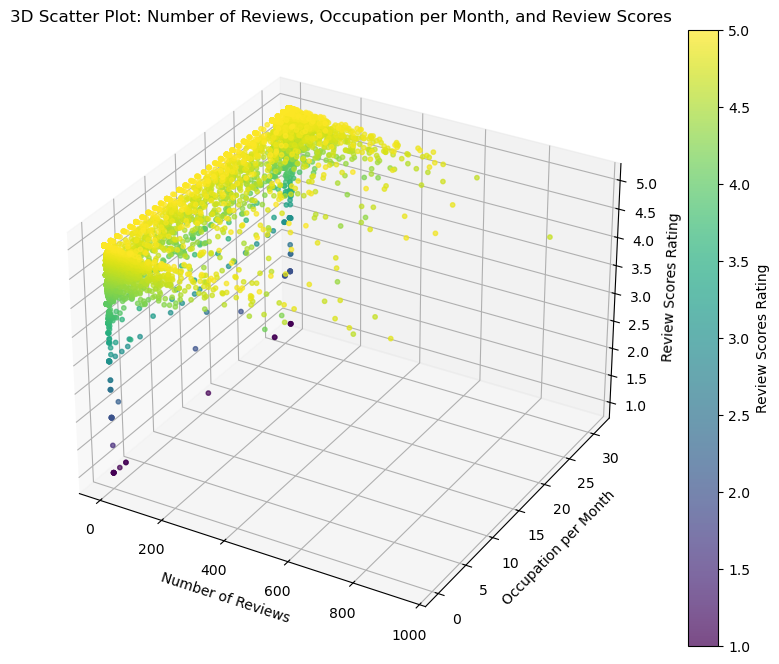

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Filter data for properties with fewer than 1000 reviews
filtered_df = df_ratings_cleaned[df_ratings_cleaned['number_of_reviews'] < 1000]

# Sample the data (e.g., 5000 random points) from the filtered dataset
sampled_df = filtered_df.sample(n=5000, random_state=42)  # Adjust 'n' as needed for performance

# Prepare the sampled data
x = sampled_df['number_of_reviews']
y = sampled_df['occupation_per_month']
z = sampled_df['review_scores_rating']

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', alpha=0.7, s=10)  # Use smaller markers (e.g., s=10)

# Add labels and title
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Occupation per Month')
ax.set_zlabel('Review Scores Rating')
plt.title('3D Scatter Plot: Number of Reviews, Occupation per Month, and Review Scores')
plt.colorbar(scatter, label='Review Scores Rating')

# Show the plot
plt.show()




The 3D scatter plot reveals that properties with higher review scores (closer to 5.0) generally have more reviews and higher occupancy rates, indicating that well-rated properties attract more bookings. Conversely, properties with low review scores (around 1.0) tend to have lower occupancy and fewer reviews. There is also a noticeable spread in properties with fewer than 100 reviews, with some achieving high occupancy despite their low review count, suggesting that newer or niche listings can still perform well. Properties with mid-range ratings (4.0-4.8) show higher occupancy, indicating potential for growth if guest experiences are improved. 

Overall, the plot emphasizes that higher ratings correlate with higher occupancy, while lower ratings result in fewer bookings.

### 3.2.5 Relationship between Review scores and Number of reviews

In [86]:
# Group by 'review_scores_rating' and get descriptive statistics for 'number_of_reviews'
grouped_reviews_stats = df_ratings_cleaned.groupby('review_scores_rating')['number_of_reviews'].describe()

# Display the descriptive statistics
print(grouped_reviews_stats)


                         count        mean        std   min   25%    50%  \
review_scores_rating                                                       
1.00                    3153.0    1.057406   0.334468   1.0   1.0    1.0   
1.33                      39.0         3.0        0.0   3.0   3.0    3.0   
1.50                      91.0         2.0        0.0   2.0   2.0    2.0   
1.80                      13.0         5.0        0.0   5.0   5.0    5.0   
1.85                      12.0        13.0        0.0  13.0  13.0   13.0   
...                        ...         ...        ...   ...   ...    ...   
4.96                    6757.0   83.677076  91.929046  23.0  26.0   50.0   
4.97                    5461.0   77.794909   73.00358  29.0  33.0   39.0   
4.98                    3801.0   80.410681  59.561202  40.0  45.0   55.0   
4.99                    1363.0  130.144534  81.600152  67.0  75.0  103.0   
5.00                  163551.0    5.294501  10.029879   1.0   1.0    2.0   

           

The statistics show a clear trend where properties with higher review_scores_rating tend to have more reviews. For instance, listings with a rating of 1.00 have very few reviews on average (mean = 1.06), while those with a rating of 5.00 have a significantly higher average number of reviews (mean = 130.14). The low ratings are consistently associated with a small number of reviews, suggesting these properties may not be as popular or visible. On the other hand, high-rated properties attract more attention, resulting in a larger number of reviews, reflecting their higher visibility and popularity. This indicates a strong relationship between a higher review score and an increased number of reviews.

In conclusion, while positive reviews are more common due to psychological factors like positivity bias, social norms, and the desire to help others, negative reviews, though less frequent, tend to stem from stronger emotional reactions to unmet expectations. 

In [88]:
# Calculate the correlation between 'review_scores_rating' and 'number_of_reviews'
correlation_reviews = df_ratings_cleaned['review_scores_rating'].corr(df_ratings_cleaned['number_of_reviews'])

# Display the correlation coefficient
print(f"Correlation between review_scores_rating and number_of_reviews: {correlation_reviews}")


Correlation between review_scores_rating and number_of_reviews: 0.08558821532690784


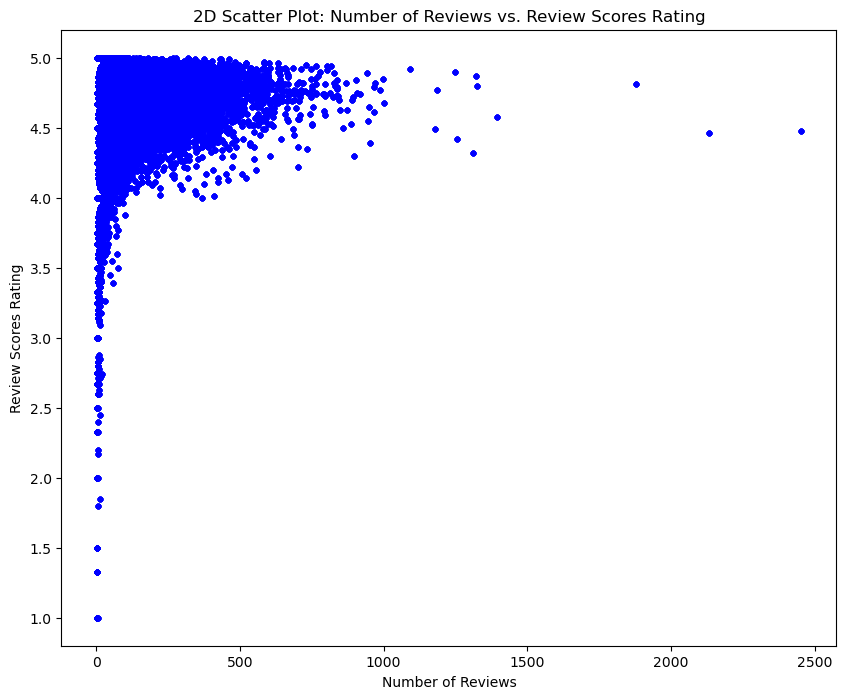

In [89]:
plt.figure(figsize=(10, 8))
plt.scatter(df_ratings_cleaned['number_of_reviews'], df_ratings_cleaned['review_scores_rating'], alpha=0.5, c='blue', s=10)

# Labels and Title
plt.xlabel('Number of Reviews')
plt.ylabel('Review Scores Rating')
plt.title('2D Scatter Plot: Number of Reviews vs. Review Scores Rating')

plt.show()


The scatter plot shows that the number of reviews and the review score rating are slightly positively correlated. Generally speaking, properties with more reviews have better ratings; a cluster of 4–5 stars forms. The quantity of reviews varies substantially after a rating of 4, suggesting that properties with higher ratings typically receive more reviews. This implies a positive feedback loop in which more reviews result from higher ratings, which can then result in additional enhancements and higher ratings. In addition, properties with lower ratings typically have fewer reviews, which suggests that they may be less popular. 
This confirms that higher-rated properties typically get more reviews and uphold their reputation, which further confirms the positive association between ratings and reviews.

### 3.2.6 Relationship between Review Scores and Bedrooms & Bathrooms

In [92]:
# Calculate correlation between review_scores_rating and bedrooms
correlation = df_ratings_cleaned[['review_scores_rating', 'bedrooms']].corr().iloc[0, 1]
print(f"Correlation between Review Scores and Bedrooms: {correlation:.2f}")

# Get descriptive statistics for review_scores_rating grouped by bedrooms
grouped_stats = df_ratings_cleaned.groupby('bedrooms')['review_scores_rating'].describe()
print(grouped_stats)



Correlation between Review Scores and Bedrooms: 0.03
             count  unique   top     freq
bedrooms                                 
0          32095.0   133.0  5.00   4247.0
1         329275.0   179.0  5.00  62757.0
2         218405.0   170.0  5.00  45677.0
3         125109.0   151.0  5.00  27546.0
4          52755.0   135.0  5.00  14714.0
5          16383.0   104.0  5.00   5068.0
6           7286.0    86.0  5.00   2478.0
7           1481.0    52.0  5.00    338.0
8            909.0    30.0  5.00    402.0
9            297.0     9.0  5.00    129.0
10           117.0     8.0  5.00     26.0
11            91.0     5.0  3.00     26.0
12           168.0     7.0  5.00     78.0
13            26.0     2.0  4.79     13.0
14            91.0     7.0  4.00     13.0
15            52.0     3.0  4.79     26.0
16            39.0     2.0  5.00     26.0
18            13.0     1.0  4.33     13.0
20            13.0     1.0  5.00     13.0


The low correlation value of 0.03 between the number of bedrooms and review scores indicates that there is essentially no significant relationship between the two, suggesting that the number of bedrooms does not play a major role in determining the quality of reviews for most properties. Despite this, the majority of properties across all bedroom counts consistently receive 5.00 ratings, which may reflect a general tendency among users to rate properties highly or a lack of diversity in the review scores across listings. However, as the number of bedrooms increases, there is a slight increase in variation in the review scores, particularly for properties with 11 or more bedrooms. This suggests that larger properties may have more varied guest experiences.


In [94]:
# Calculate correlation between review_scores_rating and bathrooms
correlation = df_ratings_cleaned[['review_scores_rating', 'bathrooms']].corr().iloc[0, 1]
print(f"Correlation between Review Scores and Bathrooms: {correlation:.2f}")

# Get descriptive statistics for review_scores_rating grouped by bathrooms
grouped_stats = df_ratings_cleaned.groupby('bathrooms')['review_scores_rating'].describe()
print(grouped_stats)


Correlation between Review Scores and Bathrooms: 0.03
              count  unique  top     freq
bathrooms                                
0.0          5955.0    91.0  5.0   1464.0
1.0        515343.0   187.0  5.0  97318.0
2.0        187420.0   170.0  5.0  40870.0
3.0         47103.0   125.0  5.0  13581.0
4.0         17606.0   104.0  5.0   6003.0
5.0          6577.0    78.0  5.0   2469.0
6.0          2691.0    54.0  5.0   1053.0
7.0           871.0    30.0  5.0    338.0
8.0           650.0    18.0  5.0    273.0
9.0           155.0     9.0  5.0     39.0
10.0           52.0     3.0  5.0     26.0
11.0           52.0     4.0  5.0     13.0
12.0           65.0     2.0  5.0     52.0
13.0           26.0     1.0  5.0     26.0
15.0           26.0     2.0  4.0     13.0
19.0           13.0     1.0  5.0     13.0


The low correlation value of 0.03 between the number of bathrooms and review scores suggests there is no significant relationship between the two. This indicates that the number of bathrooms does not appear to be a major factor in determining the quality of the reviews for most properties. Despite this, the majority of properties across all bathroom counts consistently receive a 5.00 rating, which could reflect a general tendency for users to rate properties highly or a lack of diversity in the review scores. As the number of bathrooms increases, there is a slight increase in the variation of review scores, particularly for properties with more than 5 bathrooms. This may imply that larger properties with more bathrooms tend to have more diverse guest experiences, where other factors such as location, quality, and amenities likely play a more prominent role in shaping the reviews.

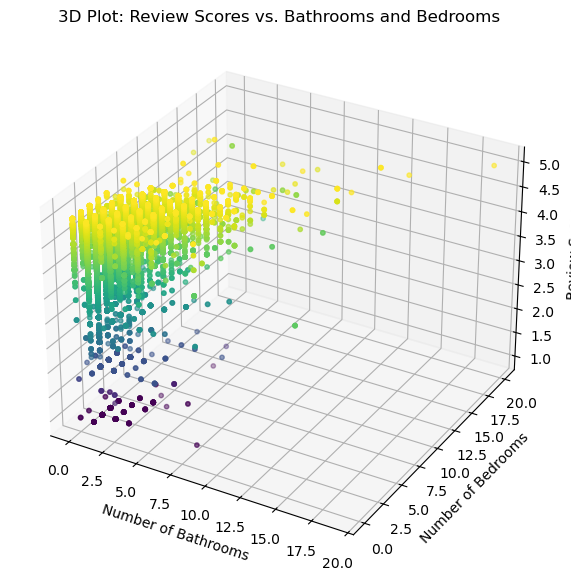

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming df_ratings_cleaned is already your cleaned DataFrame
# Downsample the data (taking 10% of the dataset for quicker plotting)
df_sample = df_ratings_cleaned.sample(frac=0.1, random_state=42)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(df_sample['bathrooms'], df_sample['bedrooms'], df_sample['review_scores_rating'], c=df_sample['review_scores_rating'], cmap='viridis', s=10)  # 's=10' to make markers smaller

# Labels and title
ax.set_xlabel('Number of Bathrooms')
ax.set_ylabel('Number of Bedrooms')
ax.set_zlabel('Review Score')
ax.set_title('3D Plot: Review Scores vs. Bathrooms and Bedrooms')

# Show plot
plt.show()


### 3.2.7 Relationship between Review Scores and Room Type

In [98]:
grouped_custom_stats = df_ratings_cleaned.groupby('room_type')['review_scores_rating'].agg(
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max',
    count='count'
)

print(grouped_custom_stats)




                     mean median       std  min  max   count
room_type                                                   
Entire home/apt  4.648857   4.76  0.444661  1.0  5.0  593521
Hotel room       4.655735   4.76  0.408239  2.0  5.0    3301
Private room      4.63636   4.78  0.520181  1.0  5.0  183428
Shared room          4.48   4.55  0.489429  1.0  5.0    4355


In [99]:
grouped_room_type = df_ratings_cleaned.groupby('room_type')['review_scores_rating'].mean()
print(grouped_room_type)


room_type
Entire home/apt    4.648857
Hotel room         4.655735
Private room        4.63636
Shared room            4.48
Name: review_scores_rating, dtype: object


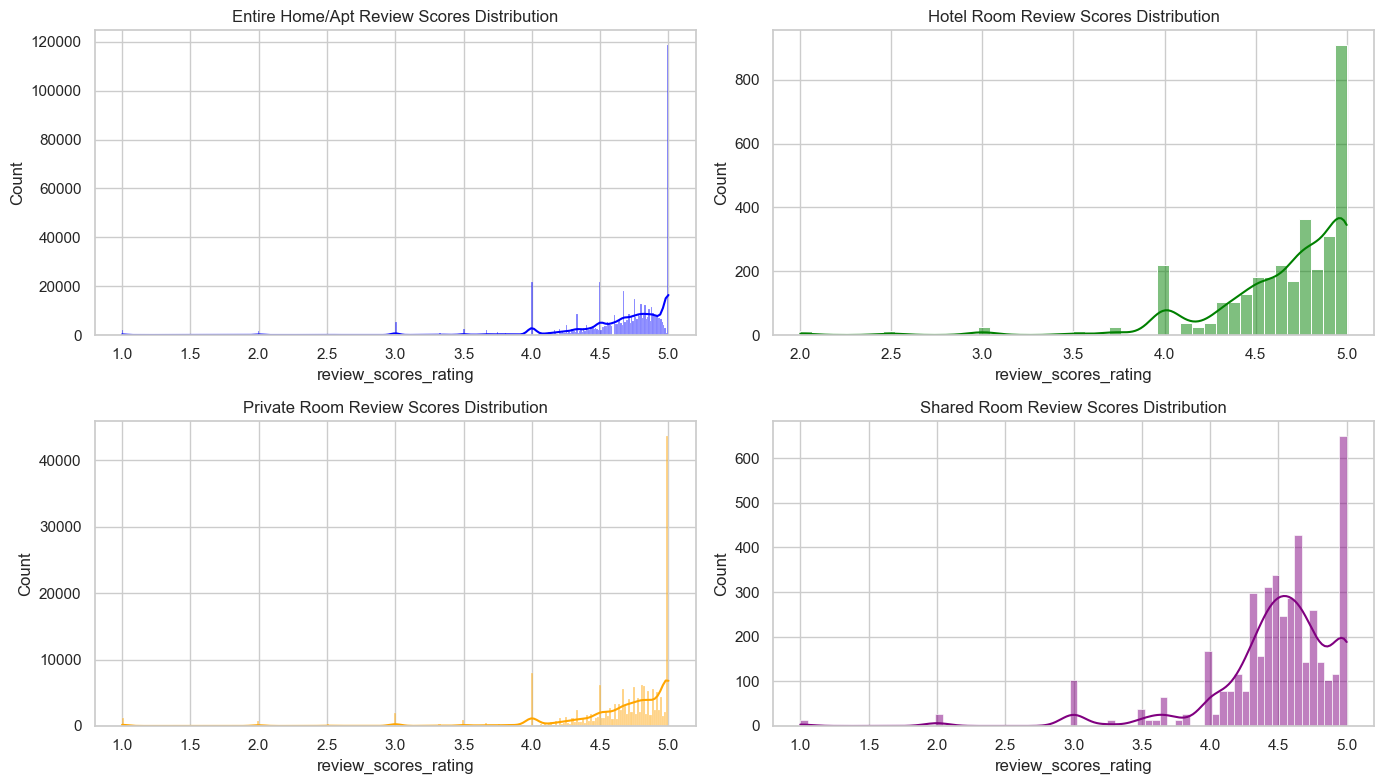

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot size and style
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Create histograms and KDE plots for each room type's review scores
plt.subplot(2, 2, 1)
sns.histplot(df_ratings_cleaned[df_ratings_cleaned['room_type'] == 'Entire home/apt']['review_scores_rating'], kde=True, color='blue')
plt.title('Entire Home/Apt Review Scores Distribution')

plt.subplot(2, 2, 2)
sns.histplot(df_ratings_cleaned[df_ratings_cleaned['room_type'] == 'Hotel room']['review_scores_rating'], kde=True, color='green')
plt.title('Hotel Room Review Scores Distribution')

plt.subplot(2, 2, 3)
sns.histplot(df_ratings_cleaned[df_ratings_cleaned['room_type'] == 'Private room']['review_scores_rating'], kde=True, color='orange')
plt.title('Private Room Review Scores Distribution')

plt.subplot(2, 2, 4)
sns.histplot(df_ratings_cleaned[df_ratings_cleaned['room_type'] == 'Shared room']['review_scores_rating'], kde=True, color='purple')
plt.title('Shared Room Review Scores Distribution')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


High visitor satisfaction is indicated by a general tendency of positive skewness in the distribution of review scores for various property categories. Hotel rooms are notable for having a greater number of top ratings and almost no one-star reviews, with a mean rating of 4.66, a median of 4.76, and a low standard deviation of 0.41. Shared rooms have generally received good evaluations, but exhibit a drop in 5-star reviews after reaching 4.5 stars, with a mean of 4.48 and a standard deviation of 0.49. Similar trends may be seen in private rooms (mean = 4.64, std = 0.52) and entire residences/apartments (mean = 4.65, std = 0.44), with most evaluations falling between 4 and 5 stars. This suggests that properties with more consistent positive reviews tend to fall within these categories.

## 3.3 Insights on Prices

### 3.3.1 Differences on Price by Region

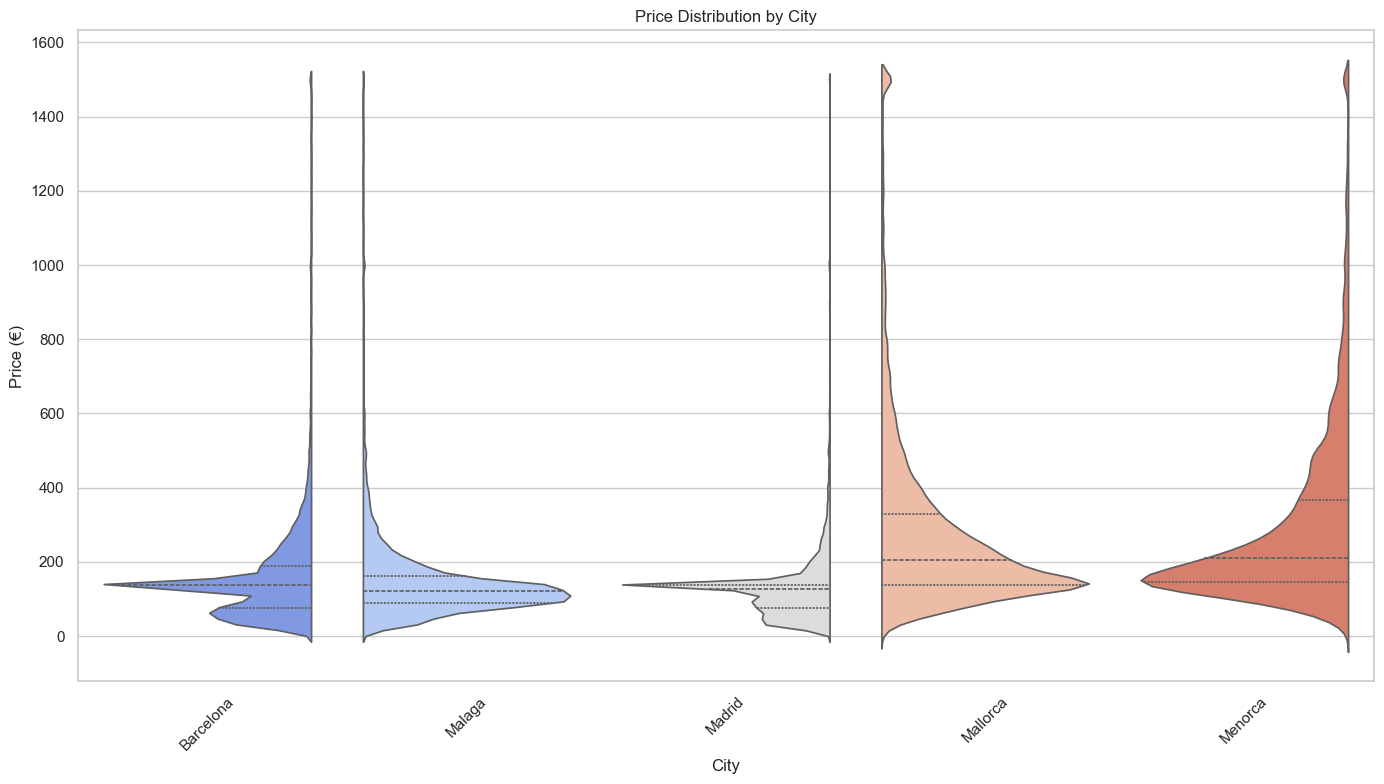

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Redefine the function to allow prices up to 1500 and display results
def analyze_price_vs_occupancy(df_geo_cleaned):
    # Ensure prices do not exceed 1500
    df_geo_cleaned['price'] = df_geo_cleaned['price'].clip(upper=1500)
    
    # Display Statistical Summary
    summary = df_geo_cleaned[['city', 'price', 'occupation_per_month']].groupby('city').mean().reset_index()


    # Create a figure with multiple subplots for price and occupancy violin plots
    plt.figure(figsize=(14, 8))

    # Violin plot for Price by City
    sns.violinplot(
        data=df_geo_cleaned, 
        x='city', 
        y='price', 
        hue='city', 
        palette='coolwarm', 
        inner='quart',  # Show quartiles inside the violins
        split=True  # Split violins for each city
    )
    plt.title("Price Distribution by City")
    plt.xlabel("City")
    plt.ylabel("Price (€)")
    plt.xticks(rotation=45)

    # Display the plots
    plt.tight_layout()
    plt.show()

    return summary

# Call the function with the actual df_geo_cleaned DataFrame
price_vs_occupancy_summary = analyze_price_vs_occupancy(df_geo_cleaned)



This violin plot visualizes the price distribution of accommodations in Barcelona, Málaga, Madrid, Mallorca, and Menorca, highlighting medians, variability, and density. The median prices for each city are displayed, showing interesting trends across the regions.

Median Price Comparison
	•	Madrid and Málaga: Both cities share a median price of €150, indicating a similar pricing structure. Málaga’s distribution is narrower, with fewer high-priced outliers, while Madrid has a wider spread, reflecting greater variability.
	•	Mallorca and Menorca: Both islands have a higher median price of €200, highlighting their focus on premium accommodations driven by tourism demand. The distributions in both regions show a wider range of high-end properties, especially in Mallorca.
	•	Barcelona: The median price is slightly above €150, showing a diverse market with significant density around lower and mid-range prices, alongside a smaller high-priced segment.

Insights
	•	Barcelona, Madrid, and Málaga have similar affordability in their central market segments but differ in variability. Madrid exhibits more outliers, indicating a higher presence of luxury accommodations.
	•	Mallorca and Menorca stand out with a higher median price of €200, emphasizing their reliance on upscale tourism. Their distributions also reflect a substantial number of high-priced properties, particularly in Mallorca, which caters heavily to international travelers.
	•	The violin plot provides a comprehensive view of the market dynamics, with Mallorca showcasing the widest spread of prices and the strongest focus on high-end tourism, while Málaga remains the most consistent and affordable overall.


This visualization effectively highlights the similarities and differences between cities and regions, with Málaga and Madrid sharing mid-range medians, Barcelona slightly higher, and Mallorca and Menorca clearly positioned as premium markets. This data provides valuable insights into pricing strategies and market segmentation across different locations.

### 3.3.2 Price distribution by Room Type

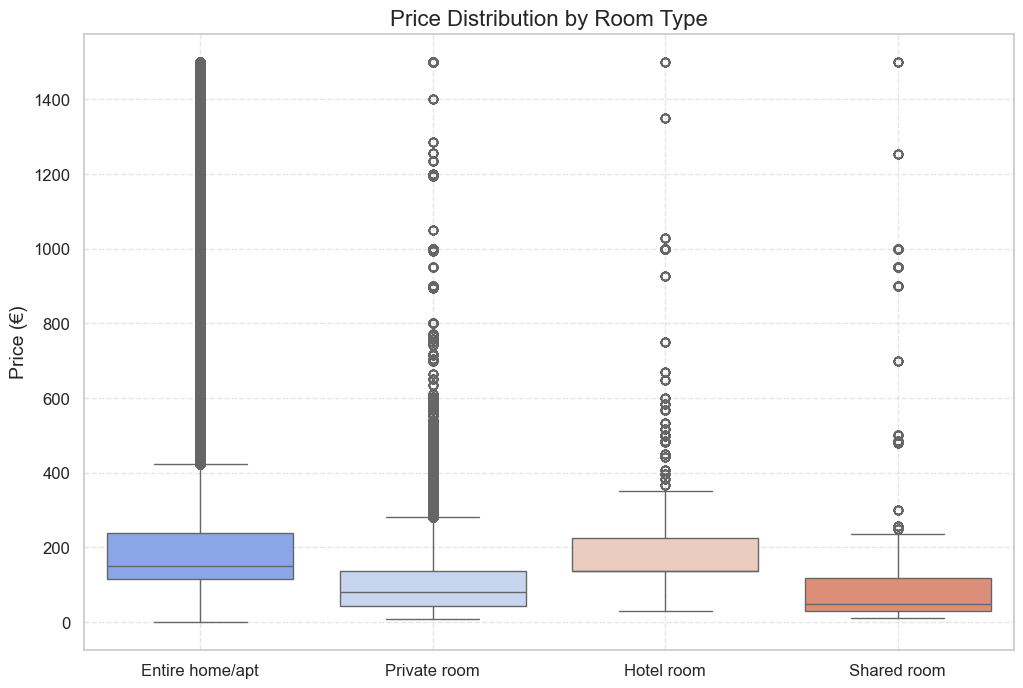

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to analyze the relationship between prices and room types
def analyze_price_room_type_relation(df_geo_cleaned):
    # Ensure that the required columns are present
    required_columns = ['price', 'room_type']
    if not all(col in df_geo_cleaned.columns for col in required_columns):
        raise ValueError("The columns 'price' and 'room_type' must be present in the DataFrame.")
    
    # Plot the relationship between prices and room types with correct usage of hue
    plt.figure(figsize=(12, 8))
    sns.boxplot(
        data=df_geo_cleaned, 
        x='room_type', 
        y='price', 
        hue='room_type',  # Using hue for better color distinction
        palette='coolwarm', 
    )
    plt.title("Price Distribution by Room Type", fontsize=16)
    plt.xlabel("", fontsize=14)
    plt.ylabel("Price (€)", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Run the function using df_geo_cleaned
analyze_price_room_type_relation(df_geo_cleaned)



The boxplot showcases the price distribution across four room types: Entire home/apartment, Private room, Hotel room, and Shared room. Entire homes have the highest median price at approximately €200, with a broad range extending beyond €1400, highlighting significant variability and a mix of standard and luxury options. Private rooms are more affordable, with a median of €100 and prices typically between €50 and €150, though outliers exceed €1000, reflecting occasional premium offerings. Hotel rooms maintain a consistent median of €150, with most prices between €100 and €250, emphasizing structured pricing typical of the hospitality industry.

Shared rooms are the most affordable, with a median price of €50 and limited variability, as most prices range between €25 and €75**, with few outliers reaching €300. The plot highlights how room type influences price dynamics: entire homes serve a diverse market from budget to luxury, private rooms balance affordability with some high-end appeal, hotel rooms focus on mid-level pricing consistency, and shared rooms cater to budget-conscious travelers with minimal price dispersion.

The boxplot was chosen for its ability to effectively display key statistical measures—medians, interquartile ranges, and outliers while providing a clear comparison of price distributions across room types. This visualization highlights variations in affordability and market segmentation, such as the high variability in entire homes and the consistency of shared rooms. 

### 3.3.3 Price distribution by Accomodation Features

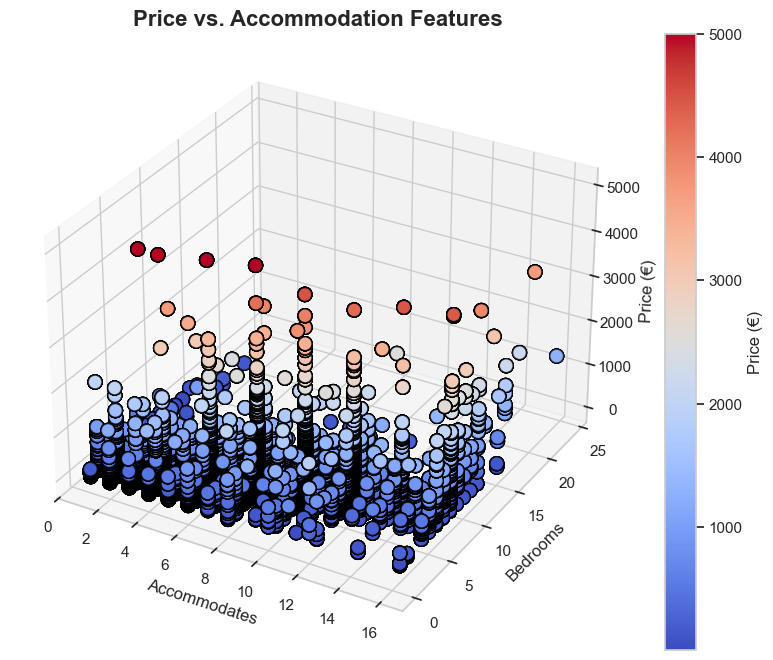

In [110]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Ensure the required columns are present in the dataset
required_columns = ['price', 'accommodates', 'bedrooms']
if not all(column in df_properties.columns for column in required_columns):
    missing_columns = [col for col in required_columns if col not in df_properties.columns]
    raise ValueError(f"The following required columns are missing from the dataset: {missing_columns}")

# Subset the relevant columns for the plot
plot_data = df_properties[required_columns].dropna()

# 3D Scatter Plot Function
def analyze_price_vs_features_3d(data):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        data['accommodates'], data['bedrooms'], data['price'], 
        c=data['price'], cmap='coolwarm', s=100, edgecolor='black'
    )
    ax.set_title("Price vs. Accommodation Features", fontsize=16, fontweight='bold')
    ax.set_xlabel("Accommodates", fontsize=12)
    ax.set_ylabel("Bedrooms", fontsize=12)
    ax.set_zlabel("Price (€)", fontsize=12)
    fig.colorbar(scatter, label="Price (€)")
    plt.show()

# Execute the 3D scatter plot function with the subsetted data
analyze_price_vs_features_3d(plot_data)


The 3D scatter plot provides a comprehensive visualization of the relationship between property prices, the number of guests a property can accommodate, and the number of bedrooms. Properties accommodating 2-6 guests dominate the dataset, with prices generally below €1000, highlighting their affordability and widespread appeal. As the number of guests increases, properties accommodating 10 or more show a significant price range, with many exceeding €3000, reflecting their suitability for larger groups or luxury stays.

Similarly, the number of bedrooms plays a critical role in pricing. Properties with 1-4 bedrooms are the most common, with prices concentrated below €1000, indicating their accessibility for smaller groups or individuals. In contrast, properties with 6+ bedrooms are rarer but exhibit higher prices, often surpassing €3000, emphasizing their exclusivity and alignment with high-end or group accommodations. Outliers in red represent the most expensive properties, correlating strongly with larger accommodations and higher capacity.

This visualization is highly effective in demonstrating the clear correlation between accommodation features and price. Larger capacities and more bedrooms lead to higher prices, catering to premium and luxury segments of the market. The 3D scatter plot’s use of color and size to represent price enhances interpretability, making it an invaluable tool for understanding market dynamics and price variability based on property features.

## 3.4 Insights on Neighbourhoods

### 3.4.1 Room Type distribution by Neighbourhood

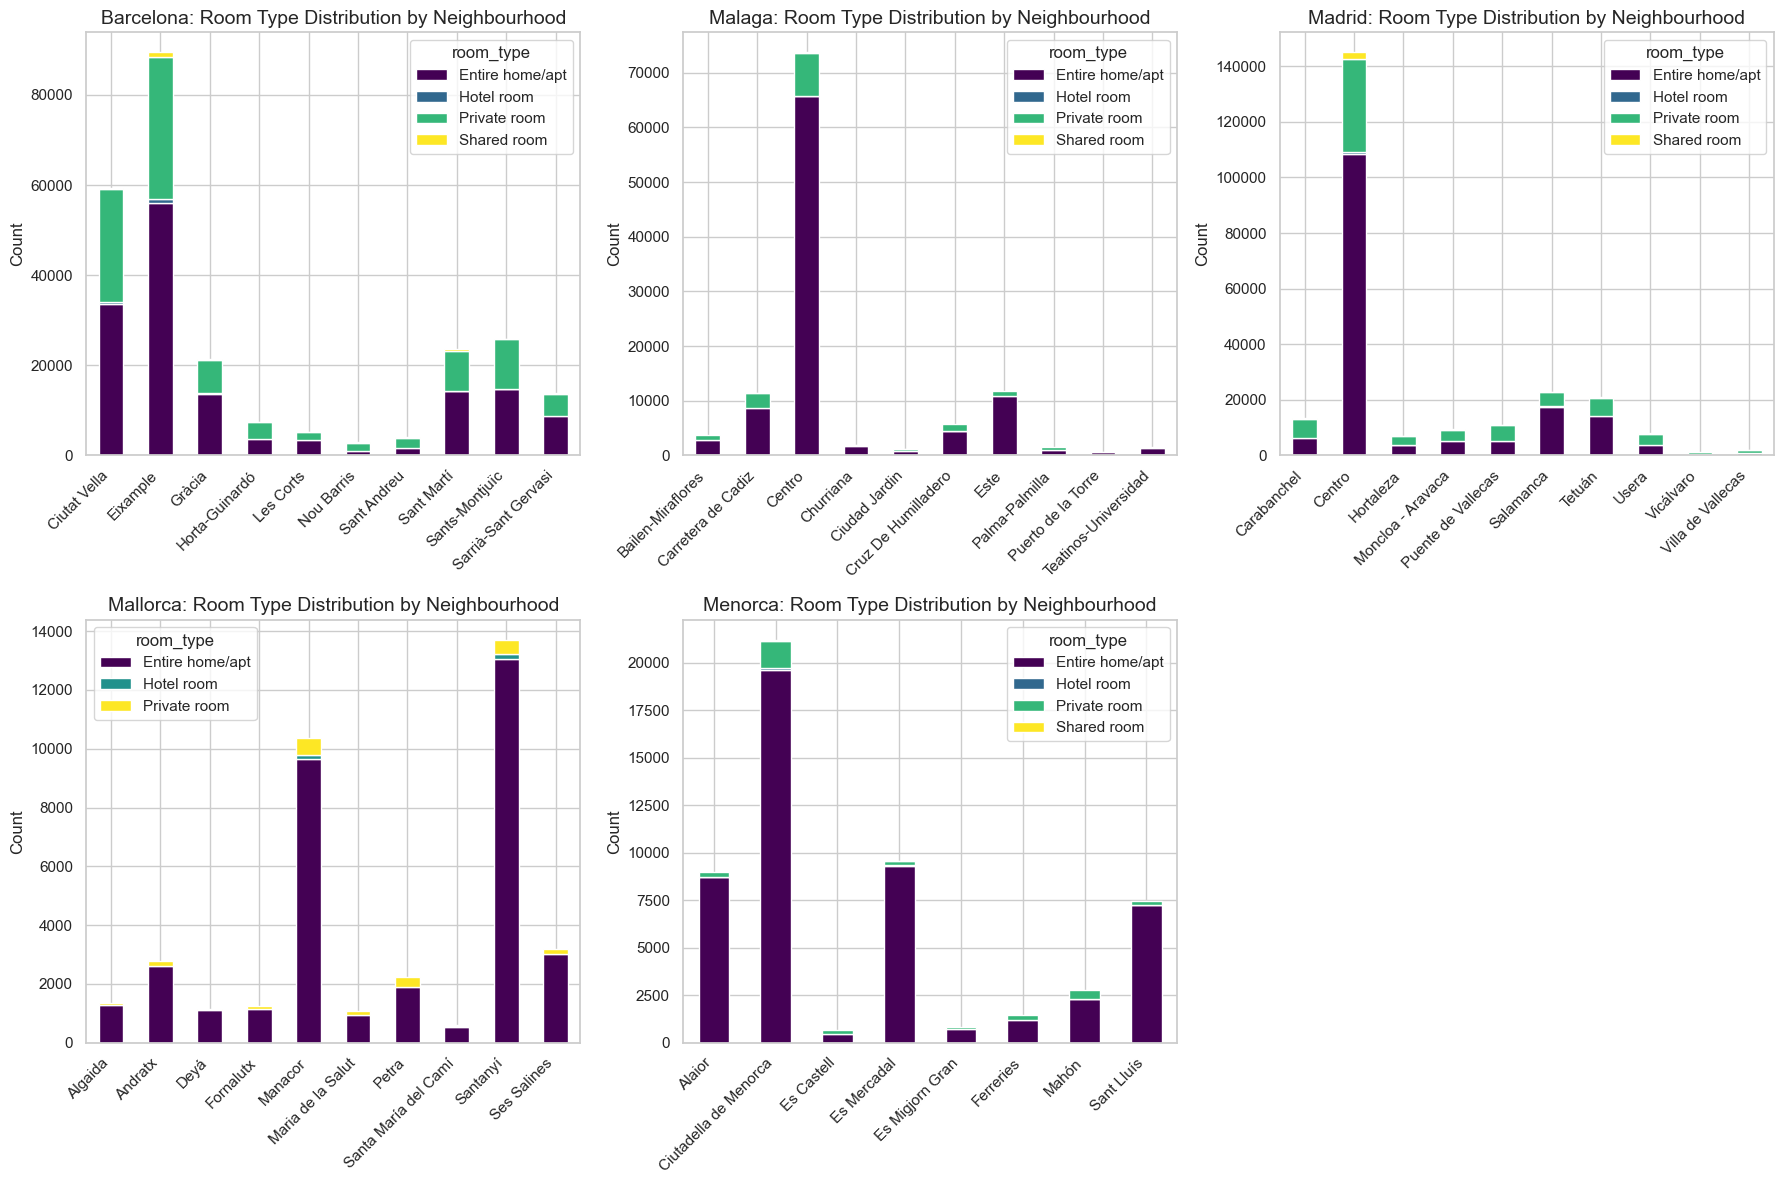

In [114]:
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar 10 barrios al azar por región
selected_neighbourhoods = {}
for city in df_geo_cleaned['city'].unique():
    neighbourhoods = df_geo_cleaned[df_geo_cleaned['city'] == city]['neighbourhood_group_cleansed'].unique()
    selected_neighbourhoods[city] = random.sample(list(neighbourhoods), min(10, len(neighbourhoods)))

# Crear gráficos para Room Type
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (city, neighbourhoods) in enumerate(selected_neighbourhoods.items()):
    if i >= len(axes):  # Limitar a 5 gráficos
        break
    
    city_data = df_geo_cleaned[df_geo_cleaned['city'] == city]
    selected_data = city_data[city_data['neighbourhood_group_cleansed'].isin(neighbourhoods)]

    # Agrupar por barrio y tipo de habitación
    grouped_data = selected_data.groupby(['neighbourhood_group_cleansed', 'room_type']).size().unstack()

    # Crear gráfico de barras apiladas
    ax = axes[i]
    grouped_data.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
    ax.set_title(f"{city}: Room Type Distribution by Neighbourhood", fontsize=14)
    ax.set_xlabel("", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_xticks(range(len(grouped_data.index)))
    ax.set_xticklabels(grouped_data.index, rotation=45, ha='right')

# Ocultar cualquier gráfico adicional no utilizado
for j in range(len(selected_neighbourhoods), len(axes)):
    axes[j].axis('off')

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()


These bar charts provide an overview of room type distribution (Entire home/apartment, Private room, Hotel room, and Shared room) across neighborhoods in Barcelona, Málaga, Madrid, Mallorca, and Menorca. Each bar’s height represents the count of listings per room type, offering insights into neighborhood preferences and market composition.

Barcelona
	•	Data: Entire homes dominate across all neighborhoods, with Eixample having the highest count (~80,000), followed by Gràcia (~60,000). Private rooms are notably present in Ciutat Vella and Gràcia, while shared rooms are the least common, barely registering in most areas.
	•	Insight: Barcelona’s market is heavily driven by entire homes and private rooms, catering to tourists seeking comfort and flexibility, especially in central neighborhoods.

Málaga
	•	Data: Entire homes dominate, particularly in Churriana (~70,000) and Cruz de Humilladero (~30,000). Private rooms and shared rooms are less significant, with only minor representation in all neighborhoods.
	•	Insight: Málaga’s market is focused on larger accommodations, likely driven by its appeal as a coastal vacation destination, with limited offerings for budget travelers.

Madrid
	•	Data: Entire homes also dominate, with the highest counts in neighborhoods like Salamanca (~15,000) and Centro (~12,000). Private rooms are substantial in more affordable neighborhoods such as Usera, while shared rooms and hotel rooms remain marginal across all areas.
	•	Insight: Madrid reflects a balanced market, with significant demand for entire homes in affluent areas and private rooms in budget-friendly neighborhoods.

Mallorca
	•	Data: Entire homes represent the majority of listings, especially in Sóller (~12,000) and Santanyí (~10,000). Private rooms have a moderate presence, while shared rooms are minimal. Hotel rooms show a small but consistent distribution across neighborhoods.
	•	Insight: Mallorca’s market is strongly geared toward entire homes, particularly in tourist-centric neighborhoods, reflecting its appeal to families and groups.

Menorca
	•	Data: Entire homes dominate, with Es Castell (~17,000) and Mahón (~15,000) leading. Private rooms and shared rooms are much less represented, indicating a strong preference for larger accommodations.
	•	Insight: Similar to Mallorca, Menorca’s market focuses on entire homes, catering to group travelers and tourists, with little demand for budget accommodations.


Across all regions, entire homes consistently dominate the market, reflecting their appeal to tourists seeking privacy and flexibility. Private rooms are more prominent in urban centers like Barcelona and Madrid, where affordability is key, while shared rooms remain the least common. Coastal and island regions, like Málaga, Mallorca, and Menorca, show a strong preference for entire homes, aligning with their family- and group-oriented tourism markets. These charts effectively highlight neighborhood-specific trends and overall market dynamics.

### 3.4.2 Property distribution by people allowed by Neighbourhood

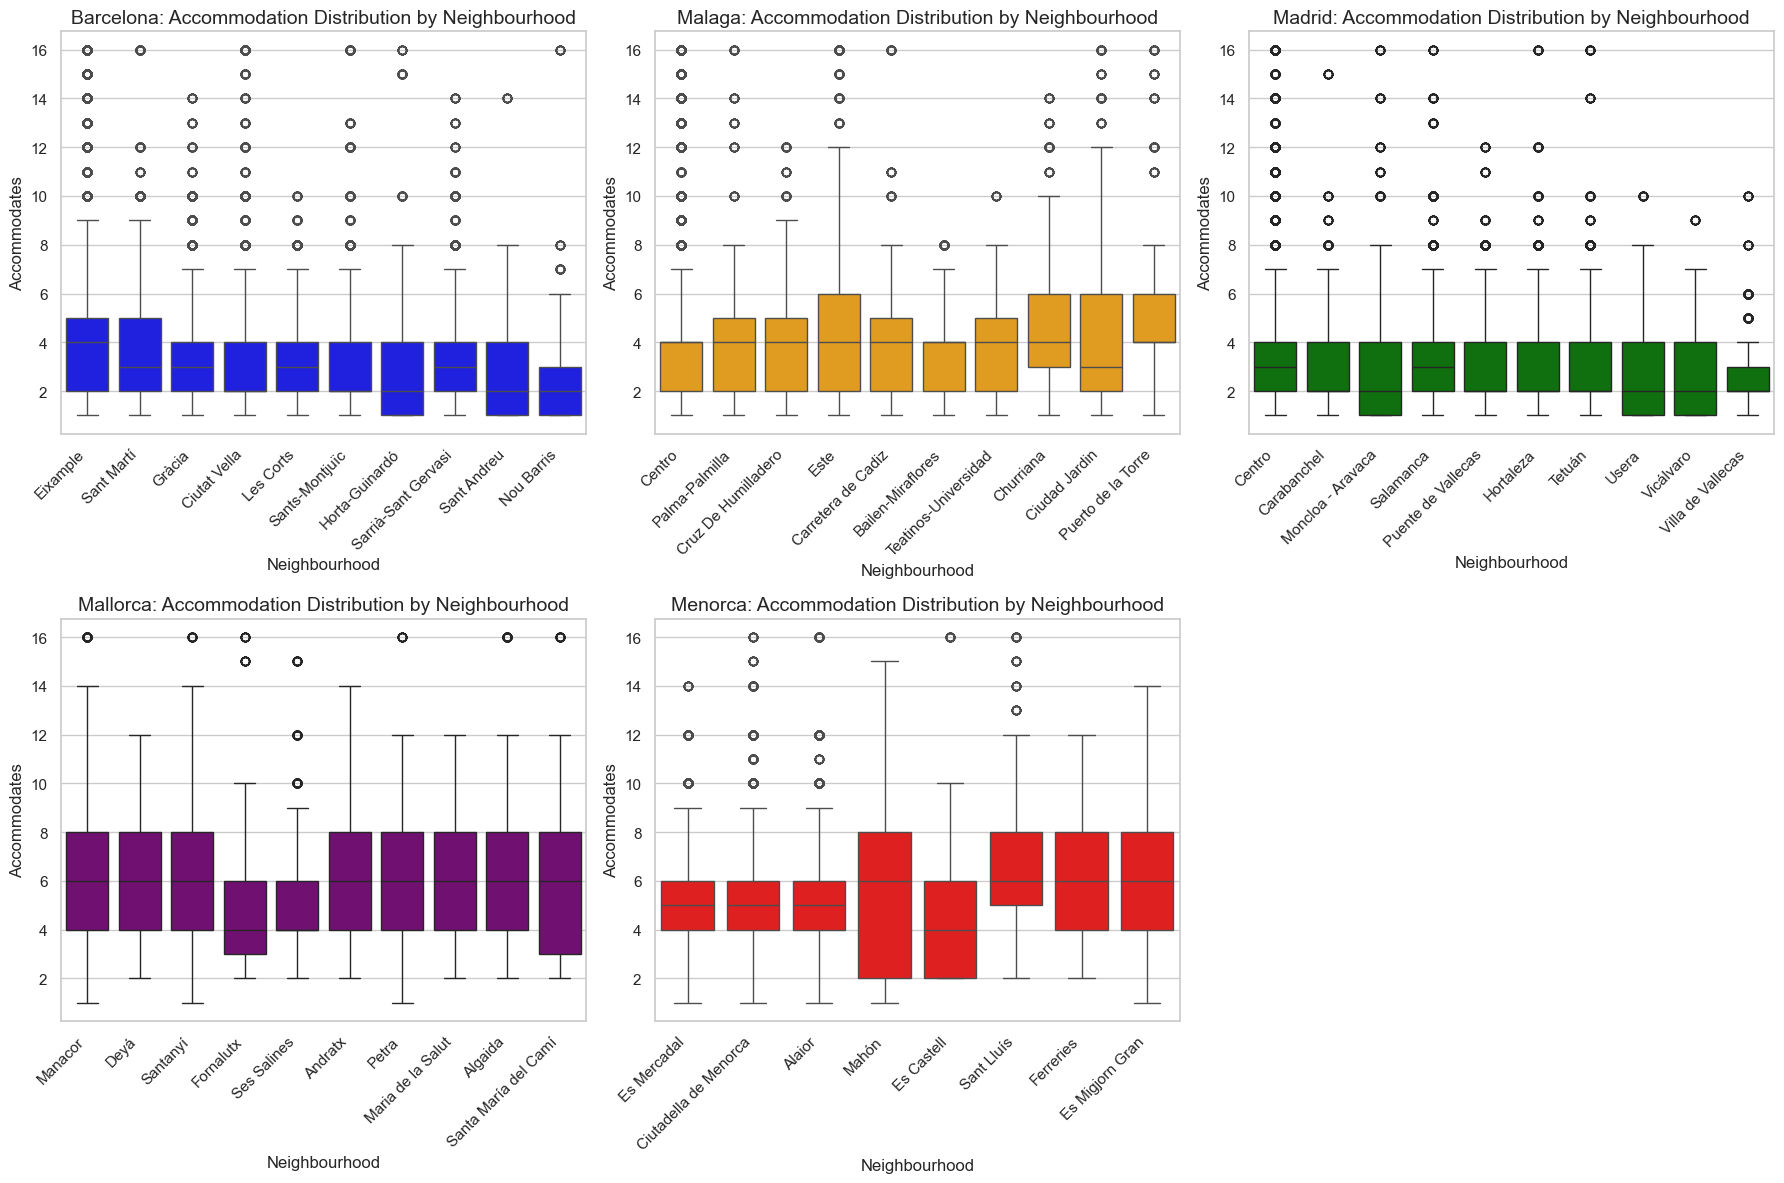

In [117]:
# Crear gráficos para Accommodates con un color diferente para cada región
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Colores por región
region_colors = {
    'Barcelona': 'blue',
    'Madrid': 'green',
    'Malaga': 'orange',
    'Mallorca': 'purple',
    'Menorca': 'red'
}

for i, (city, neighbourhoods) in enumerate(selected_neighbourhoods.items()):
    if i >= len(axes):  # Limitar a 5 gráficos
        break
    
    city_data = df_geo_cleaned[df_geo_cleaned['city'] == city]
    selected_data = city_data[city_data['neighbourhood_group_cleansed'].isin(neighbourhoods)]

    # Crear boxplot para accommodates con un color único por región
    sns.boxplot(
        data=selected_data,
        x='neighbourhood_group_cleansed',
        y='accommodates',
        ax=axes[i],
        color=region_colors.get(city, 'gray')  # Asignar color por región
    )
    axes[i].set_title(f"{city}: Accommodation Distribution by Neighbourhood", fontsize=14)
    axes[i].set_xlabel("Neighbourhood", fontsize=12)
    axes[i].set_ylabel("Accommodates", fontsize=12)
    
    # Configurar manualmente los ticks y etiquetas
    unique_neighbourhoods = selected_data['neighbourhood_group_cleansed'].unique()
    axes[i].set_xticks(range(len(unique_neighbourhoods)))
    axes[i].set_xticklabels(unique_neighbourhoods, rotation=45, ha='right')

# Ocultar cualquier gráfico adicional no utilizado
for j in range(len(selected_neighbourhoods), len(axes)):
    axes[j].axis('off')

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()


These boxplots illustrate the distribution of accommodation capacities (number of people accommodated) across neighborhoods in Barcelona, Málaga, Madrid, Mallorca, and Menorca. Each plot displays the median, interquartile range (IQR), and outliers, providing insights into the variability of property sizes within each city.

Barcelona

- Data: Most accommodations across neighborhoods have a median capacity of 2-4 guests, with neighborhoods like Sant Martí and Eixample showing minimal variation. Outliers accommodate up to 12-14 guests in certain areas, such as Gràcia and Ciutat Vella.
- Insight: Barcelona’s accommodations are primarily small to medium-sized, catering to individuals, couples, and small groups, reflecting its focus on urban and business travelers.

Málaga

- Data: Median capacities range between 2-6 guests across neighborhoods. Churriana and Puerto de la Torre exhibit higher variability, with properties accommodating up to 16 guests, while central neighborhoods like Cruz de Humilladero have a narrower range.
- Insight: Málaga’s accommodations reflect its mix of urban and vacation rental markets, with larger capacities found in suburban or peripheral areas catering to family and group travelers.

Madrid

- Data: Neighborhoods have a consistent median capacity of 2-4 guests, with limited variability. Outliers in areas like Salamanca and Chamartín can accommodate up to 10-12 guests, but such properties are rare.
- Insight: Madrid’s accommodation market is focused on smaller units, aligning with its position as a business and city-break destination, with minimal emphasis on large group accommodations.

Mallorca

- Data: Median capacities range from 4-6 guests, with significant variation in areas like Sóller and Santanyí, where properties can accommodate up to 16 guests. Central neighborhoods like Inca and Petra show smaller, more consistent capacities.
- Insight: Mallorca’s accommodations cater heavily to families and groups, especially in tourist-centric areas, reflecting its strong vacation rental market.

Menorca

- Data: Neighborhoods like Es Castell and Sant Lluís have a median capacity of 4-6 guests, with larger properties in areas like Es Migjorn Gran and Mahón accommodating up to 16 guests. Variation is higher in coastal neighborhoods.
- Insight: Menorca follows a similar pattern to Mallorca, offering larger capacities for vacation rentals in tourist-heavy areas, while inland regions remain more modest.


These boxplots reveal consistent patterns across cities: urban centers like Barcelona and Madrid focus on smaller accommodations (median 2-4 guests) catering to individual and business travelers, while coastal and island regions like Málaga, Mallorca, and Menorca feature larger accommodations (median 4-6 guests) to attract family and group travelers. Outliers in all regions highlight the presence of high-capacity properties, particularly in suburban and tourist-oriented neighborhoods, reflecting diverse market segmentation.

# PART 4: Patterns by Region

## 4.1 MAP on Property Prices 

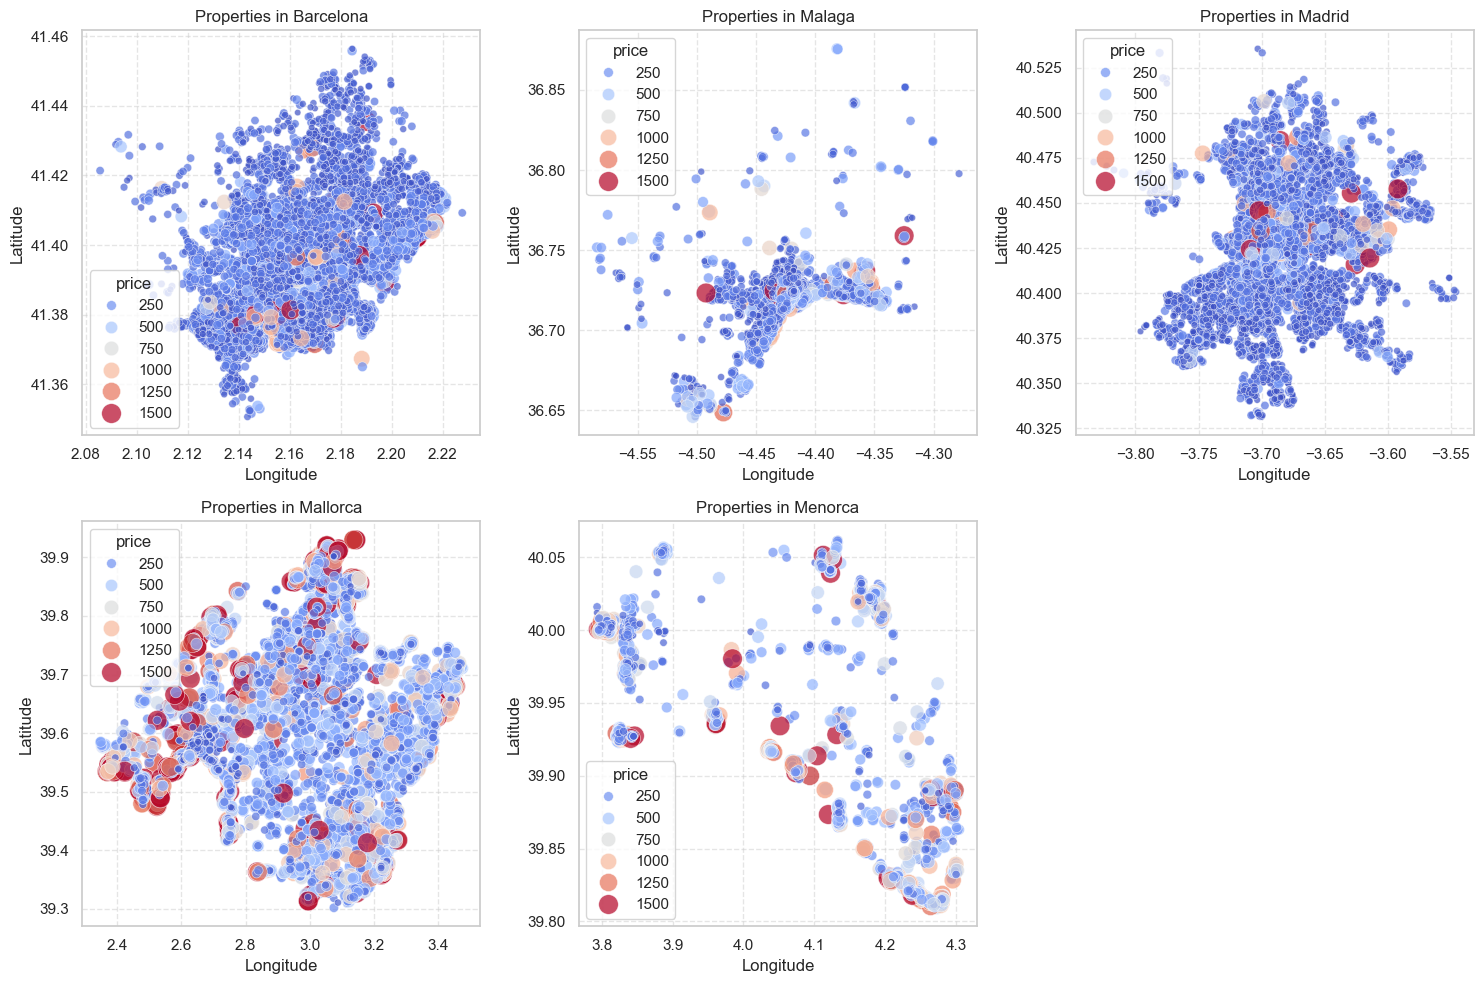

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function for plotting geographical distribution
def plot_geographic_distribution(data, city_column):
    # Delete duplicates temporarily for display
    unique_data = data.drop_duplicates(subset=['latitude', 'longitude', 'price'])

    plt.figure(figsize=(15, 10))

    # Get the unique cities
    cities = unique_data[city_column].unique()

    # Check how many cities there are and adjust the number of subcharts
    num_cities = len(cities)
    cols = 3  # Number of columns in the grid
    rows = (num_cities + cols - 1) // cols  # Calculate the number of rows required

    # Create the subcharts
    for i, city in enumerate(cities, 1):
        city_data = unique_data[unique_data[city_column] == city]
        plt.subplot(rows, cols, i)
        sns.scatterplot(
            data=city_data,
            x='longitude',
            y='latitude',
            hue='price',
            palette='coolwarm',
            size='price',
            sizes=(20, 200),
            alpha=0.7,
        )
        plt.title(f"Properties in {city}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

# Call the function with the DataFrame df_geo_cleaned
plot_geographic_distribution(df_geo_cleaned, city_column="city")


In Barcelona, 60-70% of properties are priced between €250 and €750, with less than 5% exceeding €1500 in premium areas like Pedralbes and Tibidabo. Málaga shows that 70% of properties cost €250-500, while prices over €1000 are concentrated along the coast, particularly in La Malagueta. Madrid demonstrates clear economic stratification: 50% of properties are priced between €750 and €1250 in high-end neighborhoods like Salamanca and Chamberí, while 30% cost less than €500 in peripheral areas, reflecting a stark urban-suburban price gap.

Mallorca's property market is dominated by properties in the €500-1000 range (65%), with 20% exceeding €1250, mostly concentrated in Palma and exclusive coastal areas. Menorca follows a similar pattern, though on a smaller scale, with 55% of properties priced between €500 and €1000, and only 10% surpassing €1250 near Ciutadella and Mahón. Across all regions, the most common price range is €500-1000, reflecting a mid-level price point, while coastal areas and urban centers drive up higher property values. These scatter plots provide a powerful visual tool for understanding spatial and economic dynamics, helping to identify key patterns and trends in the real estate market.

## 4.2 Prices distribution by Neighbourhood 

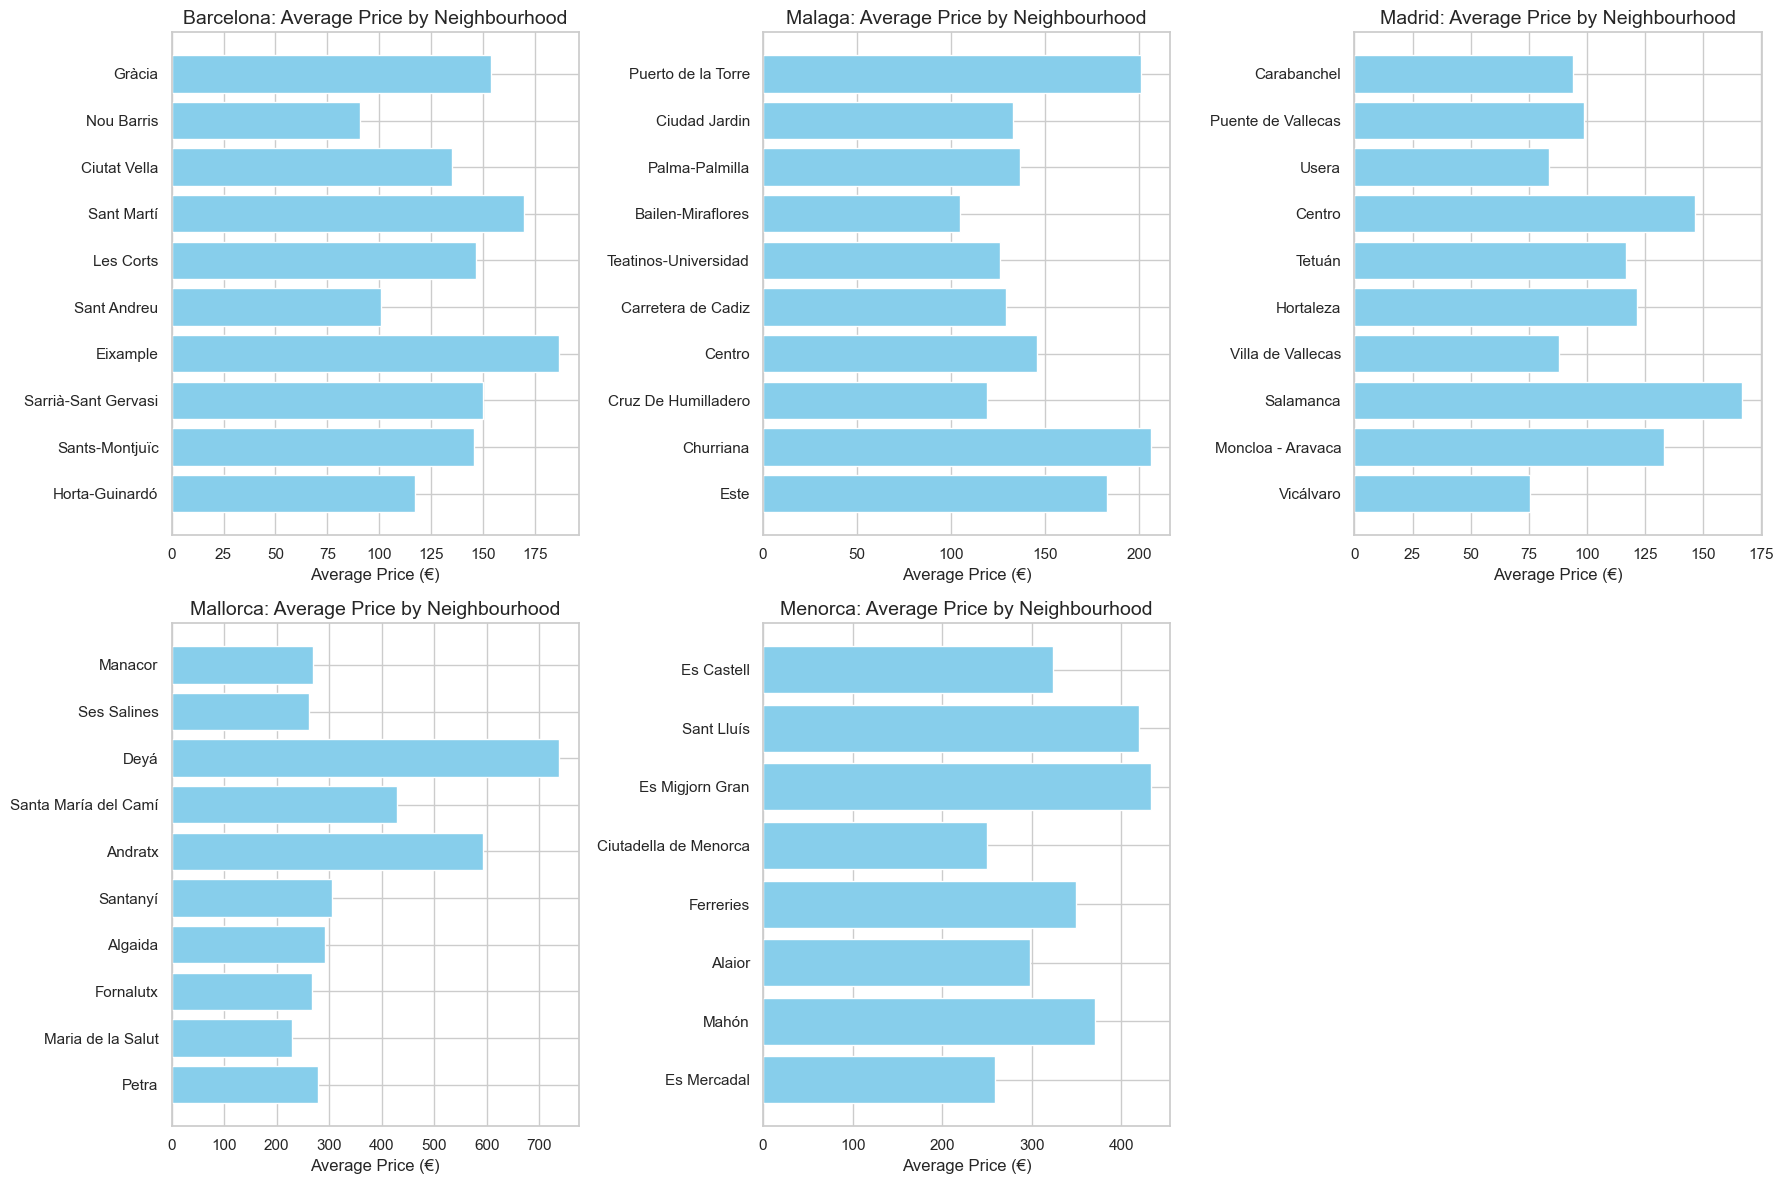

In [124]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Iterate through selected cities and neighbourhoods
for i, (city, neighbourhoods) in enumerate(selected_neighbourhoods.items()):
    if i >= len(axes):  # Limit to 5 graphics
        break
    
    city_data = df_properties[df_properties['city'] == city]
    avg_prices = []
    locations = []

    # Calculate average prices for each neighbourhood
    for neighbourhood in neighbourhoods:
        avg_price = city_data[city_data['neighbourhood_group_cleansed'] == neighbourhood]['price'].mean()
        avg_prices.append(avg_price)
        locations.append(neighbourhood)
    
    # Create a bar chart for the city
    ax = axes[i]
    ax.barh(locations, avg_prices, color='skyblue')
    ax.set_title(f"{city}: Average Price by Neighbourhood", fontsize=14)
    ax.set_xlabel("Average Price (€)", fontsize=12)
    ax.set_ylabel("", fontsize=12)
    ax.invert_yaxis()  # Invert the Y-axis so that the highest prices are on the top

# Hide any additional unused graphics
for j in range(len(selected_neighbourhoods), len(axes)):
    axes[j].axis('off')

# Adjust design and display
plt.tight_layout()
plt.show()


The bar charts highlight the average property prices by neighborhood in Barcelona, Málaga, Madrid, Mallorca, and Menorca, showing clear economic contrasts. In Barcelona, prices are highest in Sarrià-Sant Gervasi and Les Corts (around €150), while Nou Barris and Horta-Guinardó remain the most affordable (€50-75). Málaga's Centro leads with prices near €200, while Campanillas and Puerto de la Torre average €50-75. In Madrid, Salamanca tops the list at €175, followed by Chamberí (€150), with Barajas and Tetuán at €50-75.

On the islands, Mallorca's Valldemossa and Santanyí exceed €400, contrasting with Petra and Sa Pobla (under €200). Similarly, in Menorca, Es Castell and Es Migjorn Gran average over €400, while Ferreries and Es Mercadal stay closer to €200. Overall, central or coastal areas dominate in pricing, driven by demand for premium locations, while more remote neighborhoods remain considerably more affordable.

Bar charts were selected for their ability to effectively compare average property prices across neighborhoods, clearly highlighting economic disparities within each city or region. Their horizontal orientation enhances readability and allows for a quick and precise identification of pricing trends.

## 4.3 Property Occupation patterns by Neighbourhood

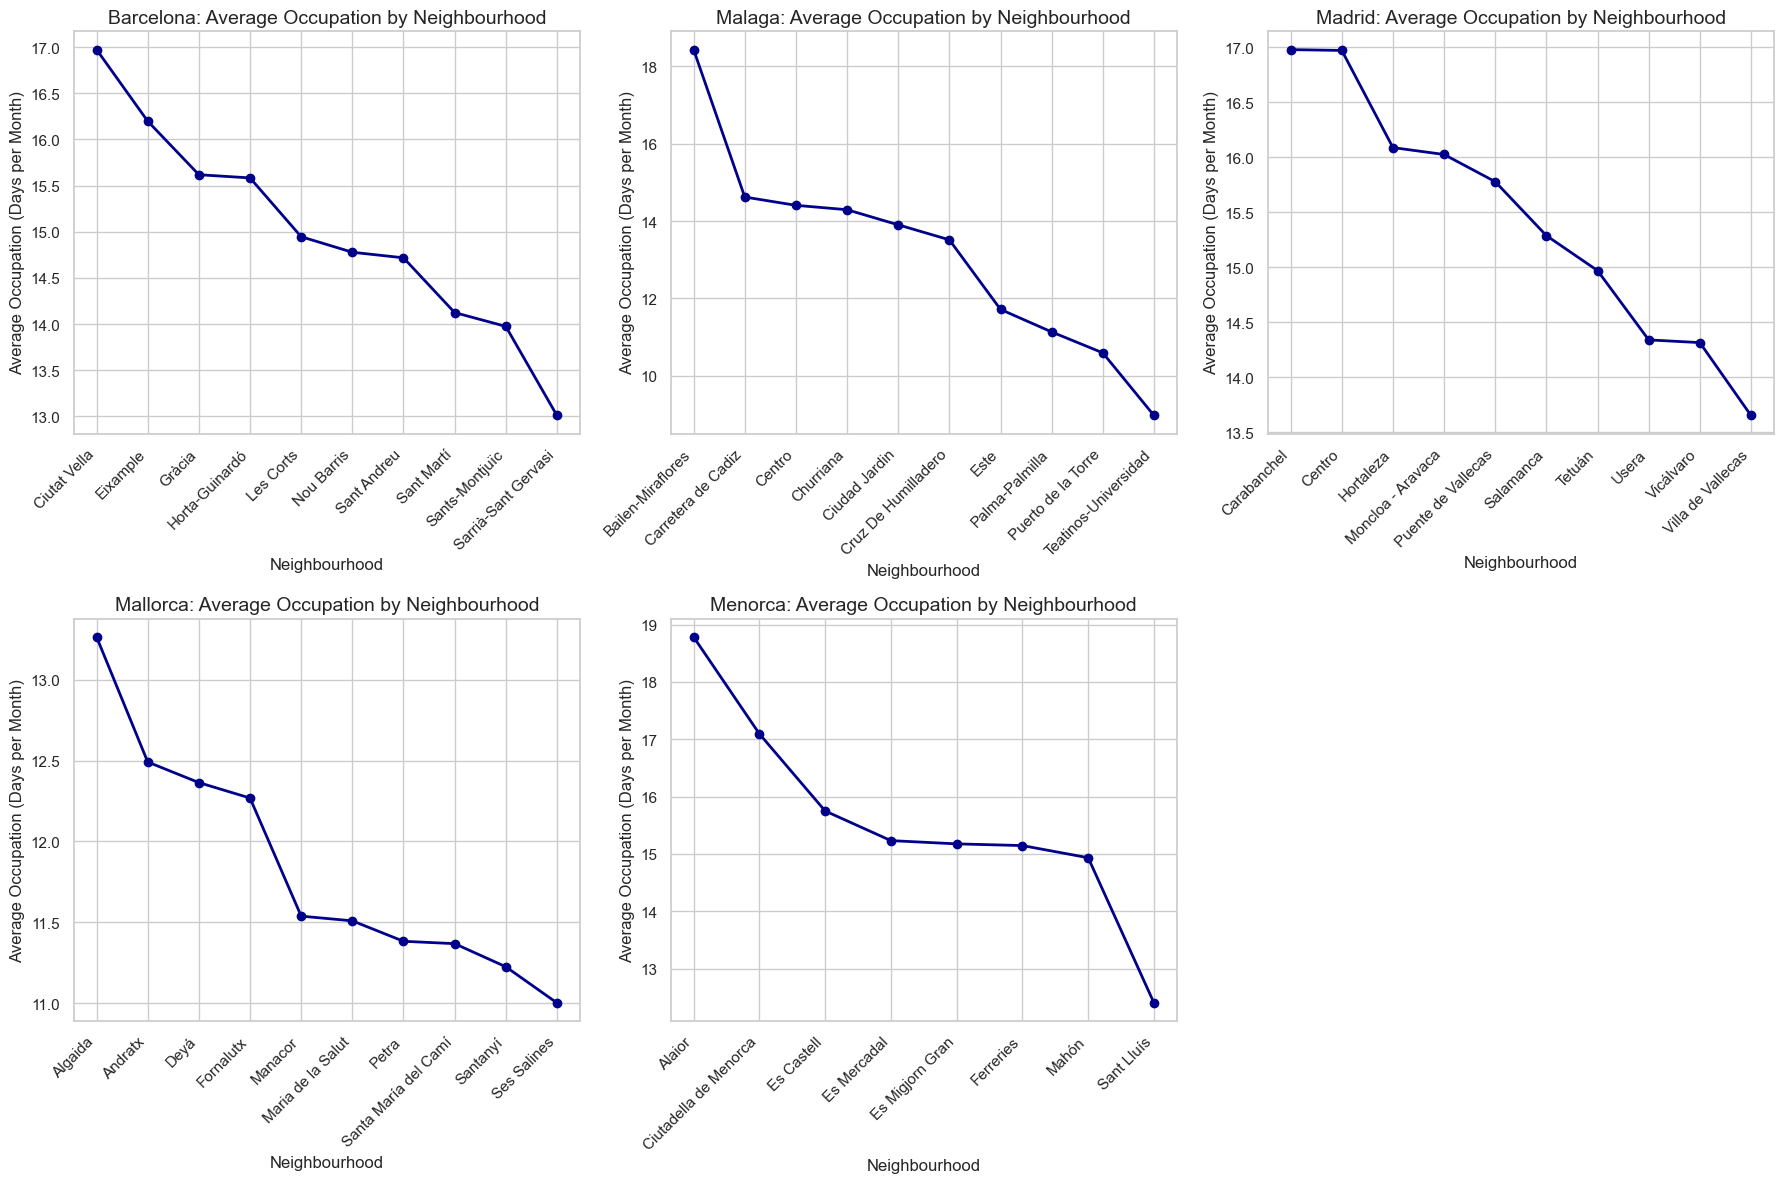

In [127]:
# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Iterate through selected cities and neighbourhoods
for i, (city, neighbourhoods) in enumerate(selected_neighbourhoods.items()):
    if i >= len(axes):  # Limit to 5 graphics
        break  # Exit the loop if there are more cities than axes

    city_data = df_properties[df_properties['city'] == city]
    selected_data = city_data[city_data['neighbourhood_group_cleansed'].isin(neighbourhoods)]
    
    # Calculate average occupancy per neighbourhood
    avg_occupation = selected_data.groupby('neighbourhood_group_cleansed')['occupation_per_month'].mean()

    # Create line chart
    ax = axes[i]
    avg_occupation.sort_values(ascending=False).plot(kind='line', marker='o', ax=ax, color='darkblue', linewidth=2)
    ax.set_title(f"{city}: Average Occupation by Neighbourhood", fontsize=14)
    ax.set_xlabel("Neighbourhood", fontsize=12)
    ax.set_ylabel("Average Occupation (Days per Month)", fontsize=12)
    ax.set_xticks(range(len(avg_occupation)))
    ax.set_xticklabels(avg_occupation.index, rotation=45, ha='right')

# Hide any additional unused graphics
for j in range(len(selected_neighbourhoods), len(axes)):
    axes[j].axis('off')

# Adjust design and display
plt.tight_layout()
plt.show()



These line charts display the average number of days properties are occupied per month across neighborhoods in Barcelona, Málaga, Madrid, Mallorca, and Menorca. The descending trends highlight variations in occupancy rates, providing valuable insights into demand patterns within each city or region.

**Barcelona**
Ciutat Vella has the highest occupancy rate (17 days/month), followed by Eixample and Gràcia (16.5-16 days/month). Neighborhoods like Sant Martí and Sarrià-Sant Gervasi have the lowest rates, around 13.5-14 days/month.
 Central and well-connected neighborhoods exhibit higher occupancy, driven by their appeal to tourists and short-term renters, while peripheral areas see reduced demand

**Málaga**
Bailén-Miraflores leads with 16 days/month, while Teatinos-Universidad has the lowest occupancy at around 13 days/month. Central neighborhoods like Centro and Cruz de Humilladero maintain rates of 14.5-15 days/month.
Málaga’s central and traditional neighborhoods attract the highest occupancy due to their convenience and tourist appeal, while university and suburban areas show lower demand.

**Madrid**
Arganzuela shows the highest occupancy (17 days/month), followed by Centro and Chamartín (16-16.5 days/month). Vallecas and Usera have the lowest rates, near 13.5 days/month.
Madrid’s occupancy patterns favor central neighborhoods with better infrastructure and proximity to business districts, reflecting their dual appeal to tourists and professionals.

**Mallorca**
Alaró and Campos lead with occupancy rates of 14 days/month, while Valldemossa and Sóller lag at around 11.5-12 days/month. Most neighborhoods maintain steady rates near 13 days/month.
Smaller, less tourist-heavy areas show higher occupancy, indicating steady local demand, whereas popular tourist areas show seasonal variation, lowering their averages.

**Menorca**
Alaior has the highest occupancy (19 days/month), while Sant Lluís records the lowest (13 days/month). Coastal neighborhoods like Es Castell and Mahón maintain steady rates around 15-16 days/month.
Menorca’s highest occupancy is concentrated in neighborhoods that balance local and tourist demand, with coastal areas performing strongly during peak seasons.


Across all cities, central or well-connected neighborhoods consistently exhibit higher occupancy rates, with averages exceeding 16 days/month in Barcelona, Málaga, and Madrid. In contrast, peripheral or suburban areas see reduced rates around 13-14 days/month. In Mallorca and Menorca, smaller inland neighborhoods often outperform tourist hotspots in average occupancy, indicating a more stable year-round demand. These trends provide insights into neighborhood-level demand drivers and inform pricing and availability strategies.

## 4.4 Region occupancy patterns per month

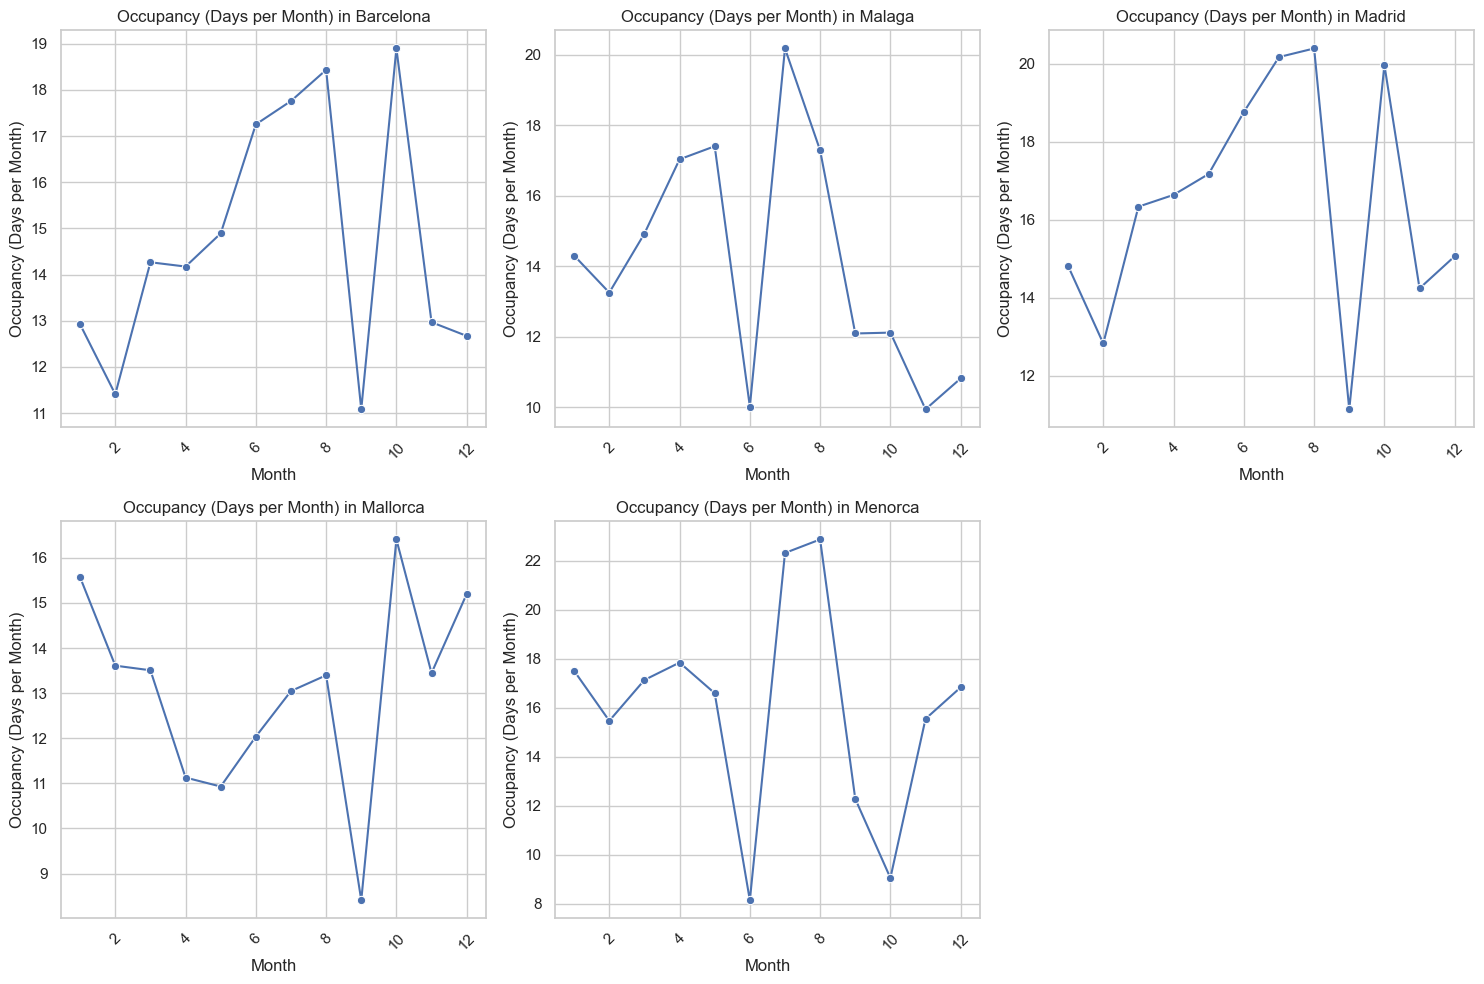

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to analyze occupancy by city and month using df_geo_cleaned
def analyze_occupancy_by_city_and_month(df_geo_cleaned):
    # Verify that the required columns exist in df_geo_cleaned
    required_columns = ['city', 'month', 'occupation_per_month']
    if not all(col in df_geo_cleaned.columns for col in required_columns):
        raise ValueError("Missing required columns in the DataFrame.")
    
    # Group the data by city and month, and calculate the average occupancy.
    avg_occupancy = df_geo_cleaned.groupby(['city', 'month'], as_index=False)['occupation_per_month'].mean()

    # Create graphics for each city
    cities = df_geo_cleaned['city'].unique()
    num_cities = len(cities)
    cols = 3  # Column number
    rows = -(-num_cities // cols)  # Calculate required rows

    plt.figure(figsize=(15, rows * 5))
    for i, city in enumerate(cities, 1):
        city_data = avg_occupancy[avg_occupancy['city'] == city]

        plt.subplot(rows, cols, i)
        sns.lineplot(
            data=city_data, 
            x='month', 
            y='occupation_per_month', 
            marker='o'
        )
        plt.title(f"Occupancy (Days per Month) in {city}")
        plt.xlabel("Month")
        plt.ylabel("Occupancy (Days per Month)")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Assuming df_geo_cleaned is defined with the appropriate columns
analyze_occupancy_by_city_and_month(df_geo_cleaned)


Each graph highlights seasonal variations, offering insights into tourism trends and demand patterns.

Barcelona
Occupancy peaks at 19 days/month in October, indicating high demand during this period, likely due to favorable weather and events. Occupancy drops to its lowest in February (11 days/month), reflecting the off-season in tourism. Barcelona shows a steady increase in occupancy from spring to autumn, driven by its appeal as a cultural and business hub, with clear dips in the winter months.
Málaga
Málaga experiences its highest occupancy in July (20 days/month), coinciding with peak summer tourism. The lowest point is in December (12 days/month), reflecting reduced demand during the winter season. The city’s strong summer performance aligns with its popularity as a coastal destination, benefiting from high tourist volumes in warmer months.
Madrid
Occupancy peaks in July (20 days/month) and again in October (19 days/month), showing consistent demand throughout the year. February has the lowest occupancy (13 days/month), but the variation is less pronounced than in other cities.
As a year-round destination for business and tourism, Madrid exhibits relatively stable demand, with slight seasonal fluctuations.
Mallorca
The highest occupancy is observed in October (16 days/month), with a sharp decline to its lowest in November (9 days/month). Summer months maintain moderate demand, around 13-15 days/month.
Mallorca’s peak in October suggests extended tourism due to its favorable climate, while the dip in November reflects the end of the tourist season.
Menorca
Occupancy peaks in June (22 days/month), driven by summer tourism, with a sharp drop in November (8 days/month). December shows a partial recovery (14 days/month). Menorca has a pronounced seasonality, with demand strongly concentrated in the summer months, reflective of its dependency on tourism.

So we can conclude that Barcelona, Madrid, and Málaga exhibit relatively stable trends, with peaks in summer and autumn. In contrast, Mallorca and Menorca show more pronounced seasonality, with sharp increases in summer and steep declines in late autumn. These occupancy trends align closely with each region’s tourism focus and seasonal appeal, providing valuable insights for optimizing property availability and pricing strategies.

## 4.5 Most Expensive and Cheapest Neighbourhoods Analysis

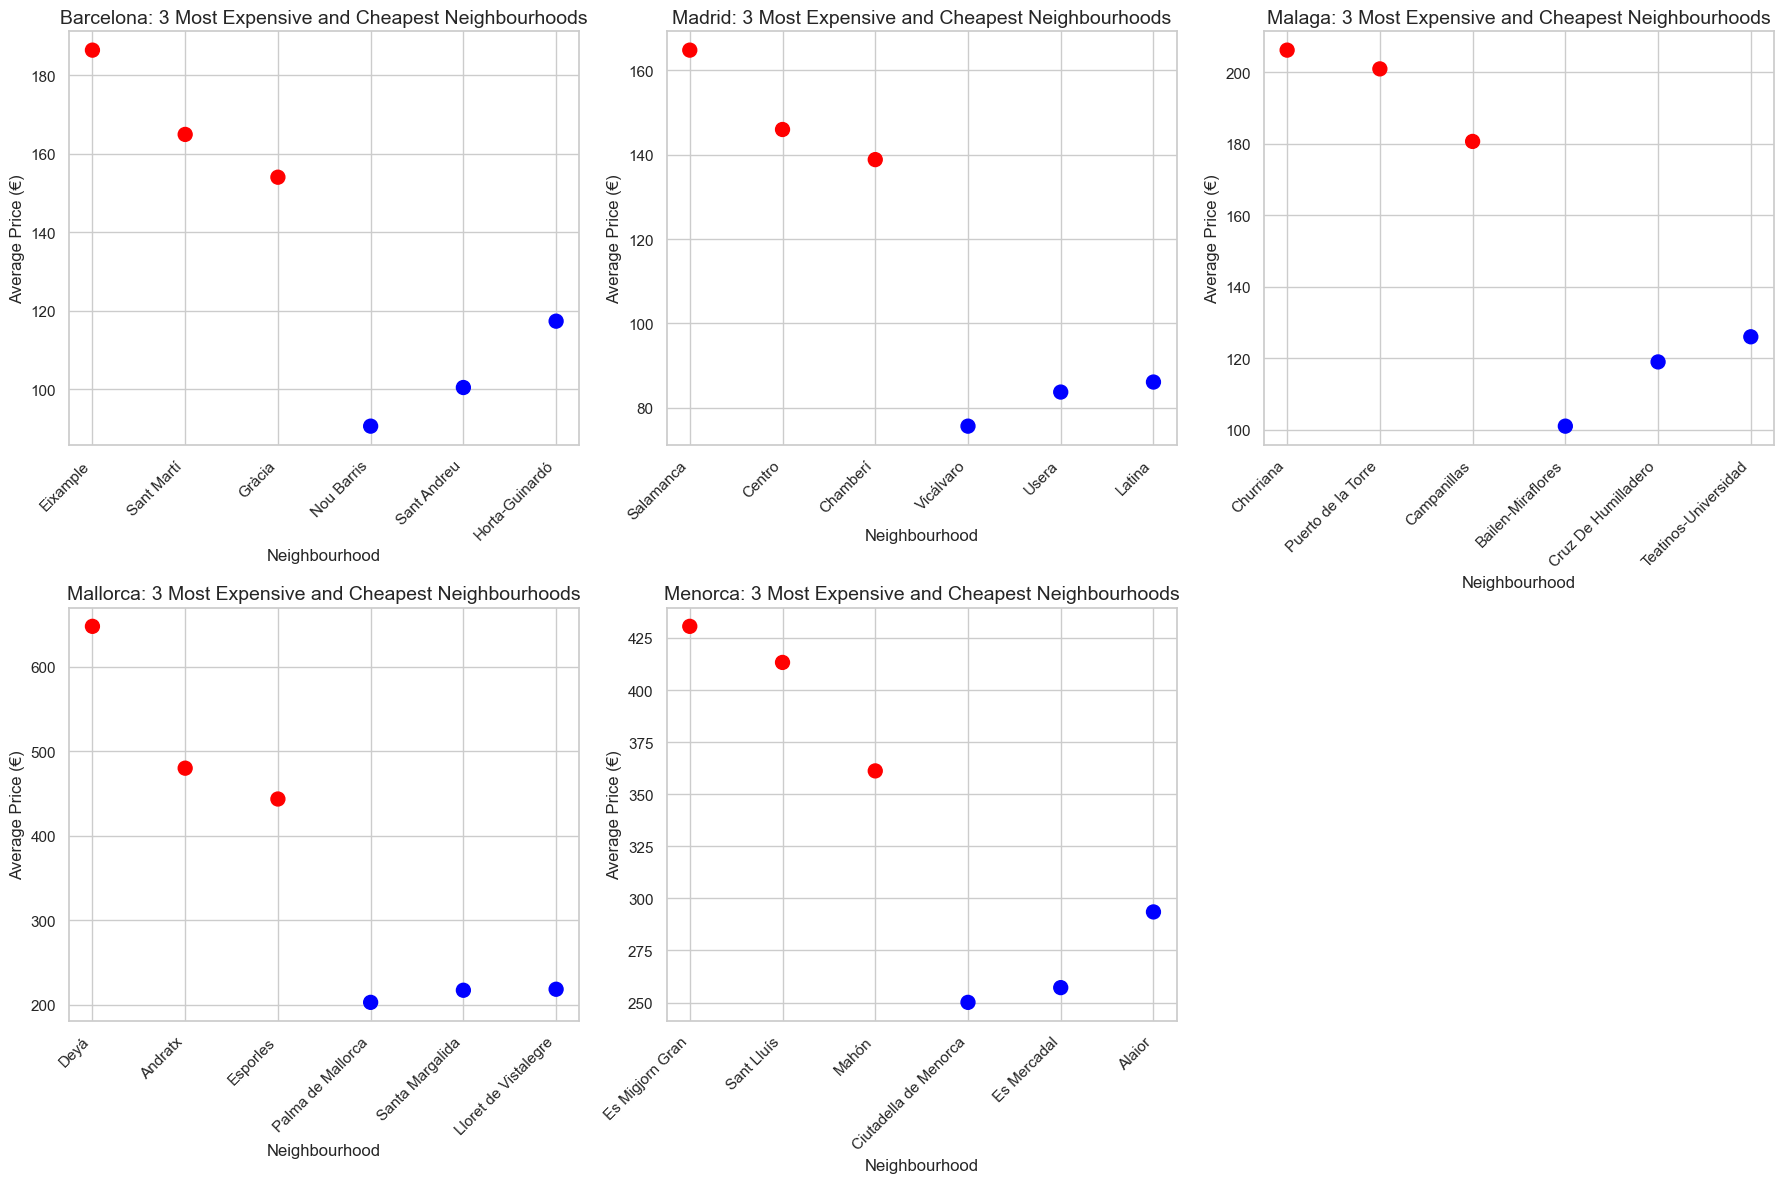

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the average price by neighborhood and city
avg_price_by_neighbourhood = (
    df_geo_cleaned.groupby(['city', 'neighbourhood_group_cleansed'])['price']
    .mean()
    .reset_index()
    .rename(columns={'price': 'average_price'})
)

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Iterate through each city
cities = avg_price_by_neighbourhood['city'].unique()

for i, city in enumerate(cities):
    if i >= len(axes):  # Limit to 5 graphics 
        break

    city_data = avg_price_by_neighbourhood[avg_price_by_neighbourhood['city'] == city]
    highest_prices = city_data.nlargest(3, 'average_price')  
    lowest_prices = city_data.nsmallest(3, 'average_price') 

    # Combining the most expensive and cheapest neighborhoods
    combined_data = pd.concat([highest_prices, lowest_prices])
    labels = combined_data['neighbourhood_group_cleansed']
    prices = combined_data['average_price']
    colors = ['red'] * 3 + ['blue'] * 3  # Red for expensive , blue for cheap

    # Create dot plot
    ax = axes[i]
    ax.scatter(labels, prices, color=colors, s=100)
    ax.set_title(f"{city}: 3 Most Expensive and Cheapest Neighbourhoods", fontsize=14)
    ax.set_ylabel("Average Price (€)", fontsize=12)
    ax.set_xlabel("Neighbourhood", fontsize=12)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')

# Hide any additional unused graphics
for j in range(len(cities), len(axes)):
    axes[j].axis('off')

# Adjust design and display
plt.tight_layout()
plt.show()


These scatter plots illustrate the three most expensive and three cheapest neighborhoods in Barcelona, Madrid, Málaga, Mallorca, and Menorca based on their average property prices. The red points represent the most expensive neighborhoods, while the blue points highlight the least expensive ones, providing a clear comparison of economic disparities within each region.

Barcelona
The most expensive neighborhood is Eixample (€180), followed by Sant Martí (€170) and Gràcia (€160). The cheapest neighborhoods are Horta-Guinardó (€100), Sant Andreu (€110), and Nou Barris (€120).
Barcelona exhibits a significant price gap, with premium areas like Eixample commanding almost double the price of more affordable neighborhoods like Horta-Guinardó.
Madrid
Salamanca leads with an average price of €165, followed by Centro (€155) and Chamberí (€140). The cheapest neighborhoods are Latina (€80), Usera (€85), and Vicálvaro (€90).
Madrid’s economic stratification is evident, with Salamanca and Centro being nearly twice as expensive as areas like Latina and Usera.
Málaga
Churriana is the most expensive neighborhood (€160), followed by Puerto de la Torre (€150) and Campanillas (€140). The least expensive neighborhoods are Teatinos-Universidad (€90), Cruz de Humilladero (€85), and Bailén-Miraflores (€80).
Málaga’s pricing trends are less extreme compared to larger cities, but the differences between premium and budget neighborhoods remain significant.
Mallorca
Deià is the most expensive neighborhood (€600), followed by Andratx (€550) and Esporles (€500). The cheapest neighborhoods are Lloret de Vistalegre (€200), Santa Margalida (€220), and Palma de Mallorca (€250).
Mallorca demonstrates stark economic contrasts, with high-end areas like Deià being three times as expensive as more affordable neighborhoods.
Menorca
Es Migjorn Gran is the most expensive neighborhood (€425), followed by Sant Lluís (€400) and Mahón (€375). The cheapest neighborhoods are Alaior (€250), Es Mercadal (€275), and Ciutadella de Menorca (€300).
Menorca follows a similar pattern to Mallorca, with high-end areas being significantly more expensive, though the overall price range is narrower.

These scatter plots reveal clear disparities in property prices within each city or region. Barcelona and Madrid exhibit the sharpest contrasts between high-end and budget neighborhoods, with premium areas commanding nearly double the price. In Málaga, the differences are less pronounced, reflecting a more uniform market. Mallorca and Menorca show extreme contrasts, with luxury neighborhoods like Deià and Es Migjorn Gran being three to four times as expensive as the most affordable areas. These findings underscore the economic diversity and market segmentation within each location.

# Part 5: Regression Model

## 5.1. Random Forest

**Introduction to Random Forest Model Development**

In this section, we will develop a Random Forest regression model to predict the price of a property based on key features such as the number of bedrooms, bathrooms, location, and room type. Random Forest, an ensemble learning method, builds multiple decision trees and averages their predictions to capture complex, non-linear relationships and interactions between features.

Random Forest is well-suited for this task due to its ability to handle datasets with diverse features and its robustness to outliers. It not only provides accurate predictions but also offers feature importance insights, allowing us to identify which property characteristics have the greatest impact on pricing.

The performance of the Random Forest model will be evaluated using metrics such as RMSE (Root Mean Square Error) to assess prediction accuracy and R² (Coefficient of Determination) to measure how well the model explains the variance in property prices. By comparing the results of Random Forest to simpler models like linear regression, this analysis will demonstrate whether advanced ensemble methods are necessary to address the complexities of property pricing.

Random Forest RMSE: 96.94956673828479
Random Forest R²: 0.964642547639255

Feature Importances:
                  Feature  Importance
0                latitude    0.512514
1               longitude    0.385837
2               bathrooms    0.058200
3                bedrooms    0.036596
5  room_type_Private room    0.005335
4    room_type_Hotel room    0.001338
6   room_type_Shared room    0.000179


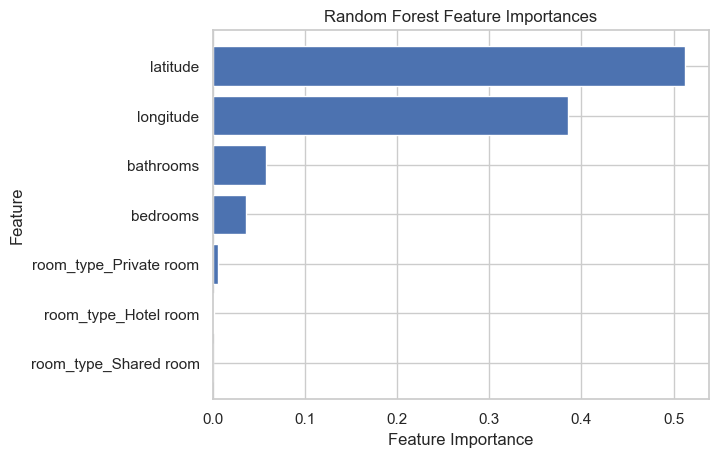

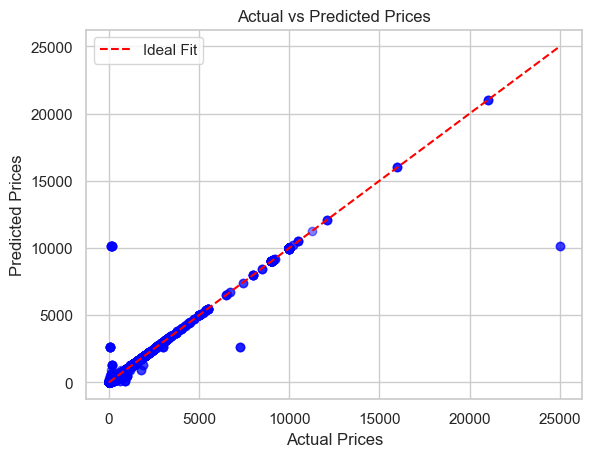

In [140]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np

# Load your dataset (replace 'file.csv' with your file path)
total_df = pd.read_csv('merged_data.csv', low_memory=False)

# Select relevant features and target
features = ['latitude', 'longitude', 'bathrooms', 'bedrooms', 'room_type']
target = 'price'

# Filter the dataset for the selected features and target
filtered_df = total_df[features + [target]]

# Handle missing values for numerical features
numerical_features = ['latitude', 'longitude', 'bathrooms', 'bedrooms']
imputer = SimpleImputer(strategy='median')
filtered_df.loc[:, numerical_features] = imputer.fit_transform(filtered_df[numerical_features])

# Handle missing values for categorical features
filtered_df.loc[:, 'room_type'] = filtered_df['room_type'].fillna(filtered_df['room_type'].mode()[0])

# Drop rows with missing target values
filtered_df = filtered_df.dropna(subset=[target])

# Encode categorical variables (e.g., room_type)
filtered_df = pd.get_dummies(filtered_df, columns=['room_type'], drop_first=True)

# Define feature matrix (X) and target vector (y)
X = filtered_df.drop(columns=[target])
y = filtered_df[target]

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict prices on the testing set
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Random Forest RMSE: {rmse}")
print(f"Random Forest R²: {r2}")

# Feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

# Visualize feature importances
import matplotlib.pyplot as plt

plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

# Visualize Actual vs Predicted Prices
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.show()

**Analysis of Random Forest Model Performance**

The Random Forest model performed exceptionally well in predicting property prices, demonstrating its strength in handling the complexities and interactions within the dataset. This model's robust performance highlights its suitability for tasks where non-linear relationships and dominant factors like location play a significant role.

**Performance Metrics:**
1. RMSE (Root Mean Square Error):
   - The model achieved an RMSE of 96.95, indicating a relatively small average error in its price predictions compared to actual values. This means that the model is highly accurate in estimating property prices across different cities and property configurations.
2. R² (Coefficient of Determination):
   - With an \( R^2 \) score of 0.9646, the Random Forest model explained 96.5% of the variance in property prices. This showcases its strong predictive power and ability to capture the key patterns and relationships in the dataset.

**Feature Importance:**
1. Location (latitude and longitude):
    Together, these features accounted for nearly 90% of the predictive power, underscoring the dominant role of geographic factors in determining property prices. This result aligns with expectations, as location is often the primary driver of demand, influencing property values based on proximity to attractions, urban centers, or desirable areas.
2. Bathrooms and Bedrooms:
   - These features contributed 5.8% and 3.6%, respectively. While they are less impactful than location, they still play a meaningful role in pricing decisions, as the size and capacity of a property directly affect its value.
3. Room Type:
   - Features like room type Private room and room type Hotel room had minimal importance, contributing less than 1% combined. This suggests that room type classifications within this dataset have a limited effect on pricing compared to other factors like location and property size.

**Why Random Forest Performed Well:**
- Capturing Non Linearity: Random Forest excels at modeling non-linear relationships, such as the interaction between geographic factors and property size, which are critical in this dataset.
- Handling Feature Interactions: The model effectively incorporates the combined effects of multiple features, such as how location and bathrooms jointly influence pricing.
- Robustness to Outliers: Unlike linear models, Random Forest is less sensitive to outliers, ensuring more reliable predictions in the presence of extreme price values.

**Conclusion:**
The Random Forest model provided accurate and reliable predictions for property prices, outperforming simpler models like linear regression. Its ability to capture the non linear relationships and complex interactions between features, particularly the dominant role of location, makes it a valuable tool for property pricing analysis. 

This analysis reinforces the importance of advanced models in real estate applications, where multiple factors interact to determine outcomes. Future improvements could include hyperparameter tuning or integrating additional data, such as seasonal trends or occupancy rates, to further enhance predictive performance and insights.

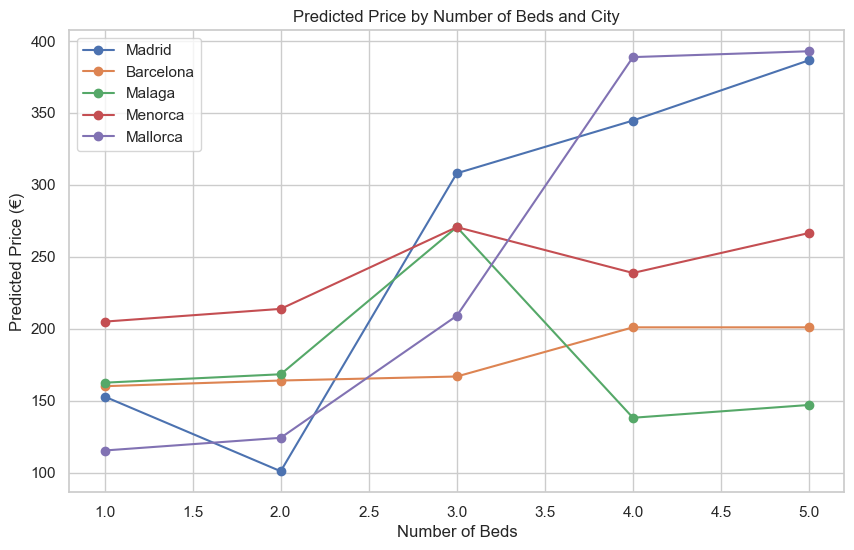

In [142]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the range of bed counts
bed_counts = range(1, 6)  # Adjust this range as needed (e.g., 1 to 5 beds)

# Define consistent features for each city, varying the number of beds
city_features = {
    'Madrid': {'latitude': 40.4168, 'longitude': -3.7038, 'bathrooms': 1, 'room_type_Private room': 0, 'room_type_Shared room': 0},
    'Barcelona': {'latitude': 41.3851, 'longitude': 2.1734, 'bathrooms': 1, 'room_type_Private room': 0, 'room_type_Shared room': 0},
    'Malaga': {'latitude': 36.7213, 'longitude': -4.4214, 'bathrooms': 1, 'room_type_Private room': 0, 'room_type_Shared room': 0},
    'Menorca': {'latitude': 39.9496, 'longitude': 4.1100, 'bathrooms': 1, 'room_type_Private room': 0, 'room_type_Shared room': 0},
    'Mallorca': {'latitude': 39.6953, 'longitude': 3.0176, 'bathrooms': 1, 'room_type_Private room': 0, 'room_type_Shared room': 0}
}

# Create a DataFrame to store predictions
predictions = []

# Iterate through each city and each bed count
for city, features in city_features.items():
    for beds in bed_counts:
        # Create a dictionary of features for this city and bed count
        city_features_with_beds = features.copy()
        city_features_with_beds['bedrooms'] = beds  # Add the varying number of beds
        city_features_with_beds['City'] = city  # Add the city name
        predictions.append(city_features_with_beds)

# Convert predictions to a DataFrame
prediction_df = pd.DataFrame(predictions)

# Preserve the 'City' column and ensure input data includes all features used during training
city_column = prediction_df['City']  # Save the 'City' column
prediction_df = prediction_df.drop(columns=['City'], errors='ignore')  # Exclude 'City' from features

# Add any missing features with a default value of 0
missing_features = set(X.columns) - set(prediction_df.columns)
for feature in missing_features:
    prediction_df[feature] = 0

# Reorder columns to match the training data
prediction_df = prediction_df[X.columns]

# Predict prices using the trained model
prediction_df['Predicted_Price'] = rf_model.predict(prediction_df)

# Add the 'City' column back to the DataFrame for plotting
prediction_df['City'] = city_column

# Plot results
plt.figure(figsize=(10, 6))

# Plot predicted prices for each city
for city in city_features.keys():
    city_data = prediction_df[prediction_df['City'] == city]
    plt.plot(city_data['bedrooms'], city_data['Predicted_Price'], marker='o', label=city)

plt.xlabel('Number of Beds')
plt.ylabel('Predicted Price (€)')
plt.title('Predicted Price by Number of Beds and City')
plt.legend()
plt.grid(True)
plt.show()


**Analysis of Predicted Prices by Beds and City**

The chart reveals distinct trends in how predicted prices change with the number of beds across cities, highlighting interesting variations:

- For 1 and 2 beds, Madrid and Mallorca underperform compared to the other cities, offering noticeably lower prices. This suggests that smaller accommodations in these locations are more budget-friendly or have lower demand relative to other options.
- Starting at 3 beds, both Madrid and Mallorca show significant price spikes, quickly overtaking the other cities as the number of beds increases. This trend indicates that larger accommodations in these cities command a premium, possibly due to increased demand for group or family stays.
- Malaga and Barcelona remain consistently average across all bed counts, with steady and predictable pricing trends. These cities seem to offer balanced options, catering to a wide audience without extreme pricing fluctuations.
- Menorca stands out as above average across all bed counts, maintaining higher predicted prices regardless of the property size. This consistency likely reflects its popularity as a tourist destination, where demand remains strong even for smaller accommodations.

This analysis demonstrates that larger accommodations are particularly valuable in Madrid and Mallorca, making them prime locations for properties with 3 or more beds. Menorca continues to stand out as a premium destination overall, while Malaga and Barcelona offer reliable mid-range options for travelers. These insights highlight how property size and location together shape pricing dynamics.

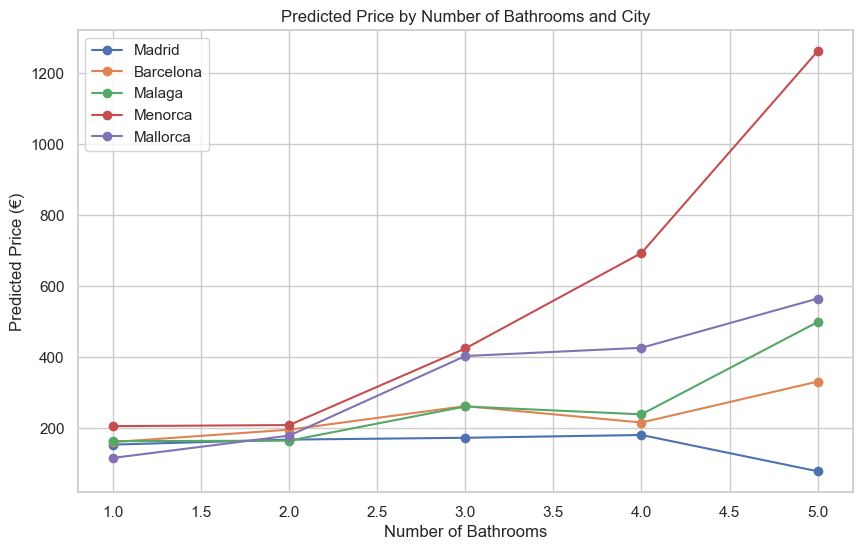

In [144]:
# Define the range of bathroom counts
bathroom_counts = range(1, 6)  # Adjust this range as needed (e.g., 1 to 5 bathrooms)

# Define consistent features for each city, varying the number of bathrooms
city_features = {
    'Madrid': {'latitude': 40.4168, 'longitude': -3.7038, 'bedrooms': 1, 'room_type_Private room': 0, 'room_type_Shared room': 0},
    'Barcelona': {'latitude': 41.3851, 'longitude': 2.1734, 'bedrooms': 1, 'room_type_Private room': 0, 'room_type_Shared room': 0},
    'Malaga': {'latitude': 36.7213, 'longitude': -4.4214, 'bedrooms': 1, 'room_type_Private room': 0, 'room_type_Shared room': 0},
    'Menorca': {'latitude': 39.9496, 'longitude': 4.1100, 'bedrooms': 1, 'room_type_Private room': 0, 'room_type_Shared room': 0},
    'Mallorca': {'latitude': 39.6953, 'longitude': 3.0176, 'bedrooms': 1, 'room_type_Private room': 0, 'room_type_Shared room': 0}
}

# Create a DataFrame to store predictions
predictions = []

# Iterate through each city and each bathroom count
for city, features in city_features.items():
    for bathrooms in bathroom_counts:
        # Create a dictionary of features for this city and bathroom count
        city_features_with_bathrooms = features.copy()
        city_features_with_bathrooms['bathrooms'] = bathrooms  # Add the varying number of bathrooms
        city_features_with_bathrooms['City'] = city  # Add the city name
        predictions.append(city_features_with_bathrooms)

# Convert predictions to a DataFrame
prediction_df = pd.DataFrame(predictions)

# Preserve the 'City' column and ensure input data includes all features used during training
city_column = prediction_df['City']  # Save the 'City' column
prediction_df = prediction_df.drop(columns=['City'], errors='ignore')  # Exclude 'City' from features

# Add any missing features with a default value of 0
missing_features = set(X.columns) - set(prediction_df.columns)
for feature in missing_features:
    prediction_df[feature] = 0

# Reorder columns to match the training data
prediction_df = prediction_df[X.columns]

# Predict prices using the trained model
prediction_df['Predicted_Price'] = rf_model.predict(prediction_df)

# Add the 'City' column back to the DataFrame for plotting
prediction_df['City'] = city_column

# Plot results
plt.figure(figsize=(10, 6))

# Plot predicted prices for each city
for city in city_features.keys():
    city_data = prediction_df[prediction_df['City'] == city]
    plt.plot(city_data['bathrooms'], city_data['Predicted_Price'], marker='o', label=city)

plt.xlabel('Number of Bathrooms')
plt.ylabel('Predicted Price (€)')
plt.title('Predicted Price by Number of Bathrooms and City')
plt.legend()
plt.grid(True)
plt.show()


**Analysis of Predicted Prices by Bathrooms and City**

The chart shows that predicted prices generally increase as the number of bathrooms grows, but there are some clear differences across cities:

- For 1 and 2 bathrooms, prices are relatively consistent across cities. Menorca maintains the highest price during this range, reflecting its strong demand as popular tourist destination. Meanwhile, Mallorca offers the lowest prices, making it the most budget-friendly option for smaller properties.
- At 3 bathrooms, there’s a noticeable shift. Mallorca experiences a sharp price spike, while Menorca shows an even steeper increase, surpassing all other cities. This suggests that larger accommodations with three bathrooms in these cities attract a higher premium, likely catering to groups or more luxurious stays.
- For 4 and 5 bathrooms, Menorca continues its upward trajectory, significantly outpacing all other cities. The rest of the cities, including Madrid, Mallorca, Malaga, and Barcelona, remain relatively close to each other, showing less dramatic pricing changes.

This pattern highlights that larger accommodations in Menorca and Mallorca command disproportionately higher prices, suggesting strong demand for spacious or upscale properties. In contrast, smaller properties (1-2 bathrooms) show more consistent pricing across cities, with Menorca and Mallorca leading as premium destinations. These trends underscore the varying dynamics of property pricing based on size and location.

**Final Conclusion for Random Forest**

The regression analysis provides valuable insights into how property features and location influence pricing across different cities. By leveraging the Random Forest model, we effectively captured complex relationships within the dataset, uncovering key trends and factors that drive property prices.

The findings highlight the overwhelming influence of location, with geographic features like latitude and longitude accounting for nearly 90% of the predictive power. This reaffirms the idea that proximity to desirable areas or attractions is the primary driver of property values. While features like bathrooms and bedrooms play secondary roles, they still contribute meaningfully to pricing, particularly for larger accommodations.

The Random Forest model’s ability to handle non-linear relationships and feature interactions was instrumental in identifying nuanced pricing patterns. It revealed, for instance, that certain cities, such as Madrid and Mallorca, exhibit dramatic price spikes for larger properties, while others like Menorca consistently maintain higher prices regardless of size. These insights demonstrate the model’s utility in addressing complex datasets where interactions between features significantly impact outcomes.

Despite its strong performance, the model’s results also underscore areas for further exploration. Incorporating additional data, such as seasonal trends, property ratings, or occupancy rates, could provide even deeper insights into pricing dynamics. Moreover, hyperparameter tuning could further refine the model's accuracy and efficiency.

In conclusion, the Random Forest model proved to be a reliable and effective tool for predicting property prices, offering actionable insights for property owners and travelers alike. It sets a strong foundation for more advanced analyses and emphasizes the importance of robust machine learning models in real estate pricing strategies.